In [1]:
import pandas as pd
import numpy as np

# # visualization 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, f1_score,precision_score, recall_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from plot_metric.functions import BinaryClassification

from sklearn.neural_network import MLPClassifier,MLPRegressor,BernoulliRBM

from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

sns.set_style("whitegrid")

In [2]:
# read the database from the computer 
data_final=pd.read_hdf("data_final.h5",key='data_final')

In [3]:
# to expand the number of columns and rows that we can see while dispalying a datafram
pd.set_option('display.max_columns', data_final.columns.shape[0]+1)
pd.set_option('display.max_rows', 200)

In [4]:
# these are the features that we have finilized to give the model 

feature_list_for_training=[
'spec_pat_num_age',
# Gender-male
'patient_gender_M',
# Specimen Collection location
'collected_in_ed', 'collected_in_hospital', 'collected_in_dsl',
# Resident During Collection
'dsl_resident_during_collection',
# Symptomatic During Collection
'symptomatic_during_collection_U', 'symptomatic_during_collection_Y',
# Result of the covid test
'interp_result_Positive',
# Specimen year-month collection
'y_m__2020-10',
'y_m__2020-11', 'y_m__2020-12', 'y_m__2020-3', 'y_m__2020-4',
'y_m__2020-5', 'y_m__2021-3', 'y_m__2020-7', 'y_m__2020-8',
'y_m__2020-9', 'y_m__2021-1', 'y_m__2021-2', 
# Num of Elixhauser 
'chf_2_years_full_1', 'htn_unc_2_years_full_1',
'cancer_mets_2_years_full_1', 'fluid_elec_dis_2_years_full_1',
'card_arrh_2_years_full_1', 'valv_dis_2_years_full_1',
'pcd_2_years_full_1', 'pvd_2_years_full_1', 'htn_c_2_years_full_1',
'paral_2_years_full_1', 'oth_neur_dis_2_years_full_1',
'cpd_2_years_full_1', 'diab_2_years_full_1',
'hypothyroidism_2_years_full_1', 'ren_fail_2_years_full_1',
'liver_dis_2_years_full_1', 'pep_ulc_exc_bld_2_years_full_1',
'aids_hiv_2_years_full_1', 'lymph_2_years_full_1',
'tumour_no_mets_2_years_full_1', 'rheum_col_vasc_dis_2_years_full_1',
'coag_2_years_full_1', 'obes_2_years_full_1', 'wt_loss_2_years_full_1',
'anemia_2_years_full_1', 'alc_abuse_2_years_full_1',
'drug_abuse_2_years_full_1', 'psych_2_years_full_1',
'depress_2_years_full_1',
#Num of Admits for 1 year
'num_admits_1_year', 'num_scu_admits_1_year',
#Num Procedures for 1 year
'num_procs_dad_1_year', 'num_procs_nacrs_1_year',
]



### Normalize the features, split into train and test and then over sample the training set

In [5]:
# select the features and normalize them 
X=data_final[feature_list_for_training]
scaler_PT = PowerTransformer() 
X = pd.DataFrame(scaler_PT.fit_transform(X), columns=X.columns)
# target
y=data_final['died_within_60_days']
# split the data into test and training 
x_train, x_test, y_train,  y_test=  train_test_split(X,y,test_size=0.1, random_state=42)
# oversampling with Random over sampler  technique 
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(x_train, y_train)

### Build the confusion_auc function to show the results 

In [6]:

# show the results 
def confusion_AUC(x_test,y_test,model,params):
    
    # comparing original and predicted values of y
    y_pred = model.predict(x_test)
    prediction = list(map(round, y_pred))

    # confusion matrix
    cm = confusion_matrix(y_test, prediction)
    print ("Confusion Matrix : \n", cm)

    # accuracy score of the model
    print('Test accuracy = ', accuracy_score(y_test, prediction))

    print(classification_report(y_test, prediction))

    print("F1 Score: {}".format(f1_score(y_test, prediction)))

    roc_auc = roc_auc_score(y_test, prediction)
    print('AUC: %.2f' % roc_auc + "%")



    # Visualisation with plot_metric
    bc = BinaryClassification(y_test, prediction, labels = ["Class 1", "Class 2"])

    # Figures
    plt.figure(figsize = (5,5))
    bc.plot_roc_curve()
    plt.show()
    
# drawing the results for hyper-parameterization
def confusion_AUC_Return(x_test,y_test,model,params):
    # comparing original and predicted values of y
    y_pred = model.predict(x_test)
    prediction = list(map(round, y_pred))
    
    # confusion matrix
    cm = confusion_matrix(y_test, prediction)


    # accuracy score of the model
    roc_auc = roc_auc_score(y_test, prediction)
    F1=f1_score(y_test, prediction)
    precision=precision_score(y_test, prediction)
    recall=recall_score(y_test, prediction)
    print('AUC: {:.2f} | F1: {:.2f} | recall: {:.2f} | precision: {:.2f}'.format(roc_auc, F1,recall,precision))



# Training the ML models with pre-processed datat (normalized the features and balanced the classes)

## 1- ANN
### Using hyper-parameterization to select the number of neurons in each hidden layer 

In [7]:

for n1 in range(1,21):
    for n2 in range(1,21):
        for n3 in range(1,21):
            clf = MLPClassifier(solver='adam', alpha=1e-5, 
                                hidden_layer_sizes=(n1,n2,n3,), 
                                random_state=43, max_iter=10000,
                                activation='relu')
            print("{},{},{}". format(n1,n2,n3))
            clf.fit(X_res,y_res)
            confusion_AUC_Return(x_test,y_test,clf,2)
            print ("----------------------------")

1,1,1
AUC: 0.72 | F1: 0.34 | recall: 0.77 | precision: 0.22
----------------------------
1,1,2
AUC: 0.71 | F1: 0.35 | recall: 0.74 | precision: 0.23
----------------------------
1,1,3
AUC: 0.72 | F1: 0.35 | recall: 0.76 | precision: 0.22
----------------------------
1,1,4
AUC: 0.71 | F1: 0.35 | recall: 0.73 | precision: 0.23
----------------------------
1,1,5
AUC: 0.71 | F1: 0.35 | recall: 0.74 | precision: 0.23
----------------------------
1,1,6
AUC: 0.71 | F1: 0.34 | recall: 0.74 | precision: 0.23
----------------------------
1,1,7
AUC: 0.72 | F1: 0.35 | recall: 0.75 | precision: 0.23
----------------------------
1,1,8
AUC: 0.71 | F1: 0.34 | recall: 0.76 | precision: 0.22
----------------------------
1,1,9
AUC: 0.70 | F1: 0.33 | recall: 0.75 | precision: 0.21
----------------------------
1,1,10
AUC: 0.71 | F1: 0.34 | recall: 0.73 | precision: 0.22
----------------------------
1,1,11
AUC: 0.71 | F1: 0.34 | recall: 0.75 | precision: 0.22
----------------------------
1,1,12
AUC: 0.72 | 

/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC: 0.50 | F1: 0.00 | recall: 0.00 | precision: 0.00
----------------------------
1,2,2
AUC: 0.71 | F1: 0.35 | recall: 0.74 | precision: 0.23
----------------------------
1,2,3
AUC: 0.71 | F1: 0.34 | recall: 0.77 | precision: 0.22
----------------------------
1,2,4
AUC: 0.71 | F1: 0.34 | recall: 0.74 | precision: 0.22
----------------------------
1,2,5
AUC: 0.72 | F1: 0.34 | recall: 0.78 | precision: 0.22
----------------------------
1,2,6
AUC: 0.71 | F1: 0.34 | recall: 0.76 | precision: 0.22
----------------------------
1,2,7
AUC: 0.71 | F1: 0.34 | recall: 0.78 | precision: 0.21
----------------------------
1,2,8
AUC: 0.71 | F1: 0.34 | recall: 0.77 | precision: 0.22
----------------------------
1,2,9
AUC: 0.72 | F1: 0.35 | recall: 0.74 | precision: 0.23
----------------------------
1,2,10
AUC: 0.71 | F1: 0.34 | recall: 0.75 | precision: 0.22
----------------------------
1,2,11
AUC: 0.71 | F1: 0.33 | recall: 0.80 | precision: 0.21
----------------------------
1,2,12
AUC: 0.71 | F1: 0.

/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC: 0.50 | F1: 0.00 | recall: 0.00 | precision: 0.00
----------------------------
1,5,2
AUC: 0.71 | F1: 0.34 | recall: 0.78 | precision: 0.21
----------------------------
1,5,3
AUC: 0.72 | F1: 0.34 | recall: 0.77 | precision: 0.22
----------------------------
1,5,4
AUC: 0.71 | F1: 0.35 | recall: 0.70 | precision: 0.23
----------------------------
1,5,5
AUC: 0.71 | F1: 0.34 | recall: 0.76 | precision: 0.22
----------------------------
1,5,6
AUC: 0.70 | F1: 0.32 | recall: 0.79 | precision: 0.20
----------------------------
1,5,7
AUC: 0.71 | F1: 0.34 | recall: 0.78 | precision: 0.21
----------------------------
1,5,8
AUC: 0.71 | F1: 0.34 | recall: 0.77 | precision: 0.22
----------------------------
1,5,9
AUC: 0.71 | F1: 0.34 | recall: 0.77 | precision: 0.22
----------------------------
1,5,10
AUC: 0.71 | F1: 0.34 | recall: 0.79 | precision: 0.21
----------------------------
1,5,11
AUC: 0.71 | F1: 0.34 | recall: 0.78 | precision: 0.22
----------------------------
1,5,12
AUC: 0.72 | F1: 0.

/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC: 0.50 | F1: 0.00 | recall: 0.00 | precision: 0.00
----------------------------
1,8,3
AUC: 0.71 | F1: 0.34 | recall: 0.78 | precision: 0.22
----------------------------
1,8,4
AUC: 0.71 | F1: 0.34 | recall: 0.78 | precision: 0.22
----------------------------
1,8,5
AUC: 0.71 | F1: 0.34 | recall: 0.77 | precision: 0.22
----------------------------
1,8,6
AUC: 0.71 | F1: 0.34 | recall: 0.78 | precision: 0.22
----------------------------
1,8,7
AUC: 0.72 | F1: 0.34 | recall: 0.78 | precision: 0.22
----------------------------
1,8,8
AUC: 0.71 | F1: 0.34 | recall: 0.75 | precision: 0.22
----------------------------
1,8,9
AUC: 0.71 | F1: 0.34 | recall: 0.76 | precision: 0.22
----------------------------
1,8,10
AUC: 0.71 | F1: 0.34 | recall: 0.78 | precision: 0.22
----------------------------
1,8,11
AUC: 0.71 | F1: 0.34 | recall: 0.75 | precision: 0.22
----------------------------
1,8,12
AUC: 0.71 | F1: 0.34 | recall: 0.76 | precision: 0.22
----------------------------
1,8,13
AUC: 0.72 | F1: 0

/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC: 0.50 | F1: 0.00 | recall: 0.00 | precision: 0.00
----------------------------
1,11,2
AUC: 0.71 | F1: 0.33 | recall: 0.79 | precision: 0.21
----------------------------
1,11,3
AUC: 0.72 | F1: 0.34 | recall: 0.78 | precision: 0.22
----------------------------
1,11,4
AUC: 0.71 | F1: 0.34 | recall: 0.76 | precision: 0.22
----------------------------
1,11,5
AUC: 0.71 | F1: 0.34 | recall: 0.76 | precision: 0.22
----------------------------
1,11,6
AUC: 0.70 | F1: 0.32 | recall: 0.80 | precision: 0.20
----------------------------
1,11,7
AUC: 0.71 | F1: 0.34 | recall: 0.77 | precision: 0.22
----------------------------
1,11,8
AUC: 0.72 | F1: 0.34 | recall: 0.78 | precision: 0.22
----------------------------
1,11,9
AUC: 0.71 | F1: 0.33 | recall: 0.77 | precision: 0.21
----------------------------
1,11,10
AUC: 0.72 | F1: 0.35 | recall: 0.75 | precision: 0.23
----------------------------
1,11,11
AUC: 0.71 | F1: 0.34 | recall: 0.78 | precision: 0.21
----------------------------
1,11,12
AUC: 0.

/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC: 0.50 | F1: 0.00 | recall: 0.00 | precision: 0.00
----------------------------
1,12,2


/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC: 0.50 | F1: 0.00 | recall: 0.00 | precision: 0.00
----------------------------
1,12,3
AUC: 0.71 | F1: 0.34 | recall: 0.76 | precision: 0.22
----------------------------
1,12,4
AUC: 0.71 | F1: 0.33 | recall: 0.79 | precision: 0.21
----------------------------
1,12,5
AUC: 0.71 | F1: 0.34 | recall: 0.77 | precision: 0.22
----------------------------
1,12,6
AUC: 0.71 | F1: 0.34 | recall: 0.78 | precision: 0.21
----------------------------
1,12,7
AUC: 0.71 | F1: 0.35 | recall: 0.75 | precision: 0.23
----------------------------
1,12,8
AUC: 0.71 | F1: 0.33 | recall: 0.77 | precision: 0.21
----------------------------
1,12,9
AUC: 0.71 | F1: 0.33 | recall: 0.81 | precision: 0.20
----------------------------
1,12,10
AUC: 0.71 | F1: 0.34 | recall: 0.76 | precision: 0.22
----------------------------
1,12,11
AUC: 0.71 | F1: 0.33 | recall: 0.79 | precision: 0.21
----------------------------
1,12,12
AUC: 0.72 | F1: 0.34 | recall: 0.79 | precision: 0.22
----------------------------
1,12,13
AUC: 0

/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC: 0.50 | F1: 0.00 | recall: 0.00 | precision: 0.00
----------------------------
1,13,2


/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC: 0.50 | F1: 0.00 | recall: 0.00 | precision: 0.00
----------------------------
1,13,3
AUC: 0.71 | F1: 0.34 | recall: 0.77 | precision: 0.22
----------------------------
1,13,4
AUC: 0.71 | F1: 0.34 | recall: 0.77 | precision: 0.22
----------------------------
1,13,5
AUC: 0.71 | F1: 0.33 | recall: 0.80 | precision: 0.21
----------------------------
1,13,6
AUC: 0.71 | F1: 0.33 | recall: 0.80 | precision: 0.20
----------------------------
1,13,7
AUC: 0.69 | F1: 0.32 | recall: 0.71 | precision: 0.21
----------------------------
1,13,8
AUC: 0.71 | F1: 0.34 | recall: 0.77 | precision: 0.22
----------------------------
1,13,9
AUC: 0.70 | F1: 0.32 | recall: 0.81 | precision: 0.20
----------------------------
1,13,10
AUC: 0.71 | F1: 0.33 | recall: 0.78 | precision: 0.21
----------------------------
1,13,11
AUC: 0.72 | F1: 0.34 | recall: 0.79 | precision: 0.22
----------------------------
1,13,12
AUC: 0.71 | F1: 0.33 | recall: 0.79 | precision: 0.21
----------------------------
1,13,13
AUC: 0

AUC: 0.71 | F1: 0.34 | recall: 0.76 | precision: 0.22
----------------------------
1,17,14
AUC: 0.71 | F1: 0.34 | recall: 0.75 | precision: 0.22
----------------------------
1,17,15
AUC: 0.71 | F1: 0.33 | recall: 0.81 | precision: 0.21
----------------------------
1,17,16
AUC: 0.71 | F1: 0.33 | recall: 0.78 | precision: 0.21
----------------------------
1,17,17
AUC: 0.71 | F1: 0.33 | recall: 0.79 | precision: 0.21
----------------------------
1,17,18
AUC: 0.72 | F1: 0.35 | recall: 0.78 | precision: 0.22
----------------------------
1,17,19
AUC: 0.68 | F1: 0.32 | recall: 0.70 | precision: 0.21
----------------------------
1,17,20
AUC: 0.72 | F1: 0.34 | recall: 0.78 | precision: 0.22
----------------------------
1,18,1
AUC: 0.50 | F1: 0.20 | recall: 1.00 | precision: 0.11
----------------------------
1,18,2
AUC: 0.71 | F1: 0.33 | recall: 0.81 | precision: 0.21
----------------------------
1,18,3


/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC: 0.50 | F1: 0.00 | recall: 0.00 | precision: 0.00
----------------------------
1,18,4
AUC: 0.71 | F1: 0.34 | recall: 0.77 | precision: 0.22
----------------------------
1,18,5
AUC: 0.72 | F1: 0.34 | recall: 0.77 | precision: 0.22
----------------------------
1,18,6
AUC: 0.72 | F1: 0.34 | recall: 0.77 | precision: 0.22
----------------------------
1,18,7
AUC: 0.71 | F1: 0.33 | recall: 0.79 | precision: 0.21
----------------------------
1,18,8
AUC: 0.71 | F1: 0.34 | recall: 0.75 | precision: 0.22
----------------------------
1,18,9
AUC: 0.70 | F1: 0.33 | recall: 0.77 | precision: 0.21
----------------------------
1,18,10
AUC: 0.71 | F1: 0.33 | recall: 0.77 | precision: 0.21
----------------------------
1,18,11
AUC: 0.70 | F1: 0.32 | recall: 0.81 | precision: 0.20
----------------------------
1,18,12
AUC: 0.71 | F1: 0.34 | recall: 0.76 | precision: 0.22
----------------------------
1,18,13
AUC: 0.70 | F1: 0.32 | recall: 0.77 | precision: 0.20
----------------------------
1,18,14
AUC: 

/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC: 0.50 | F1: 0.00 | recall: 0.00 | precision: 0.00
----------------------------
1,20,3
AUC: 0.71 | F1: 0.34 | recall: 0.76 | precision: 0.22
----------------------------
1,20,4
AUC: 0.71 | F1: 0.33 | recall: 0.81 | precision: 0.21
----------------------------
1,20,5
AUC: 0.71 | F1: 0.34 | recall: 0.73 | precision: 0.23
----------------------------
1,20,6
AUC: 0.71 | F1: 0.33 | recall: 0.80 | precision: 0.21
----------------------------
1,20,7
AUC: 0.69 | F1: 0.32 | recall: 0.78 | precision: 0.20
----------------------------
1,20,8
AUC: 0.71 | F1: 0.34 | recall: 0.76 | precision: 0.22
----------------------------
1,20,9
AUC: 0.72 | F1: 0.35 | recall: 0.74 | precision: 0.23
----------------------------
1,20,10
AUC: 0.71 | F1: 0.33 | recall: 0.80 | precision: 0.21
----------------------------
1,20,11
AUC: 0.70 | F1: 0.31 | recall: 0.82 | precision: 0.19
----------------------------
1,20,12
AUC: 0.70 | F1: 0.33 | recall: 0.76 | precision: 0.21
----------------------------
1,20,13
AUC: 0

AUC: 0.68 | F1: 0.32 | recall: 0.70 | precision: 0.21
----------------------------
2,4,15
AUC: 0.70 | F1: 0.33 | recall: 0.72 | precision: 0.22
----------------------------
2,4,16
AUC: 0.71 | F1: 0.34 | recall: 0.74 | precision: 0.22
----------------------------
2,4,17
AUC: 0.69 | F1: 0.33 | recall: 0.70 | precision: 0.22
----------------------------
2,4,18
AUC: 0.70 | F1: 0.34 | recall: 0.73 | precision: 0.22
----------------------------
2,4,19
AUC: 0.70 | F1: 0.33 | recall: 0.74 | precision: 0.21
----------------------------
2,4,20
AUC: 0.70 | F1: 0.33 | recall: 0.75 | precision: 0.21
----------------------------
2,5,1
AUC: 0.72 | F1: 0.35 | recall: 0.77 | precision: 0.22
----------------------------
2,5,2


/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC: 0.50 | F1: 0.00 | recall: 0.00 | precision: 0.00
----------------------------
2,5,3
AUC: 0.71 | F1: 0.35 | recall: 0.75 | precision: 0.22
----------------------------
2,5,4
AUC: 0.72 | F1: 0.35 | recall: 0.76 | precision: 0.23
----------------------------
2,5,5
AUC: 0.70 | F1: 0.33 | recall: 0.75 | precision: 0.21
----------------------------
2,5,6
AUC: 0.71 | F1: 0.33 | recall: 0.81 | precision: 0.21
----------------------------
2,5,7
AUC: 0.70 | F1: 0.34 | recall: 0.72 | precision: 0.22
----------------------------
2,5,8
AUC: 0.70 | F1: 0.34 | recall: 0.70 | precision: 0.23
----------------------------
2,5,9
AUC: 0.71 | F1: 0.34 | recall: 0.76 | precision: 0.22
----------------------------
2,5,10
AUC: 0.71 | F1: 0.35 | recall: 0.71 | precision: 0.23
----------------------------
2,5,11
AUC: 0.69 | F1: 0.33 | recall: 0.71 | precision: 0.21
----------------------------
2,5,12
AUC: 0.68 | F1: 0.32 | recall: 0.69 | precision: 0.21
----------------------------
2,5,13
AUC: 0.71 | F1: 0

AUC: 0.71 | F1: 0.34 | recall: 0.76 | precision: 0.22
----------------------------
2,9,15
AUC: 0.70 | F1: 0.33 | recall: 0.75 | precision: 0.21
----------------------------
2,9,16
AUC: 0.68 | F1: 0.31 | recall: 0.73 | precision: 0.20
----------------------------
2,9,17
AUC: 0.70 | F1: 0.34 | recall: 0.70 | precision: 0.23
----------------------------
2,9,18
AUC: 0.70 | F1: 0.33 | recall: 0.74 | precision: 0.21
----------------------------
2,9,19
AUC: 0.68 | F1: 0.31 | recall: 0.77 | precision: 0.19
----------------------------
2,9,20
AUC: 0.70 | F1: 0.33 | recall: 0.74 | precision: 0.21
----------------------------
2,10,1
AUC: 0.72 | F1: 0.35 | recall: 0.74 | precision: 0.23
----------------------------
2,10,2


/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC: 0.50 | F1: 0.00 | recall: 0.00 | precision: 0.00
----------------------------
2,10,3
AUC: 0.69 | F1: 0.32 | recall: 0.70 | precision: 0.21
----------------------------
2,10,4
AUC: 0.71 | F1: 0.34 | recall: 0.75 | precision: 0.22
----------------------------
2,10,5
AUC: 0.70 | F1: 0.33 | recall: 0.73 | precision: 0.21
----------------------------
2,10,6
AUC: 0.71 | F1: 0.34 | recall: 0.75 | precision: 0.22
----------------------------
2,10,7
AUC: 0.69 | F1: 0.34 | recall: 0.66 | precision: 0.23
----------------------------
2,10,8
AUC: 0.70 | F1: 0.34 | recall: 0.71 | precision: 0.22
----------------------------
2,10,9
AUC: 0.69 | F1: 0.32 | recall: 0.70 | precision: 0.21
----------------------------
2,10,10
AUC: 0.70 | F1: 0.33 | recall: 0.76 | precision: 0.21
----------------------------
2,10,11
AUC: 0.69 | F1: 0.32 | recall: 0.74 | precision: 0.21
----------------------------
2,10,12
AUC: 0.67 | F1: 0.30 | recall: 0.77 | precision: 0.18
----------------------------
2,10,13
AUC: 0

AUC: 0.69 | F1: 0.34 | recall: 0.67 | precision: 0.23
----------------------------
2,14,14
AUC: 0.70 | F1: 0.34 | recall: 0.73 | precision: 0.22
----------------------------
2,14,15
AUC: 0.70 | F1: 0.34 | recall: 0.73 | precision: 0.22
----------------------------
2,14,16
AUC: 0.68 | F1: 0.31 | recall: 0.74 | precision: 0.20
----------------------------
2,14,17
AUC: 0.70 | F1: 0.32 | recall: 0.83 | precision: 0.19
----------------------------
2,14,18
AUC: 0.69 | F1: 0.33 | recall: 0.73 | precision: 0.21
----------------------------
2,14,19
AUC: 0.71 | F1: 0.33 | recall: 0.79 | precision: 0.21
----------------------------
2,14,20
AUC: 0.69 | F1: 0.33 | recall: 0.73 | precision: 0.21
----------------------------
2,15,1
AUC: 0.71 | F1: 0.34 | recall: 0.75 | precision: 0.22
----------------------------
2,15,2
AUC: 0.71 | F1: 0.33 | recall: 0.78 | precision: 0.21
----------------------------
2,15,3
AUC: 0.70 | F1: 0.34 | recall: 0.74 | precision: 0.22
----------------------------
2,15,4
AUC

/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC: 0.50 | F1: 0.00 | recall: 0.00 | precision: 0.00
----------------------------
2,17,2
AUC: 0.70 | F1: 0.32 | recall: 0.76 | precision: 0.21
----------------------------
2,17,3
AUC: 0.71 | F1: 0.34 | recall: 0.76 | precision: 0.22
----------------------------
2,17,4
AUC: 0.70 | F1: 0.33 | recall: 0.76 | precision: 0.21
----------------------------
2,17,5
AUC: 0.70 | F1: 0.33 | recall: 0.76 | precision: 0.21
----------------------------
2,17,6
AUC: 0.69 | F1: 0.32 | recall: 0.75 | precision: 0.20
----------------------------
2,17,7
AUC: 0.72 | F1: 0.35 | recall: 0.76 | precision: 0.22
----------------------------
2,17,8
AUC: 0.69 | F1: 0.31 | recall: 0.85 | precision: 0.19
----------------------------
2,17,9
AUC: 0.69 | F1: 0.33 | recall: 0.71 | precision: 0.21
----------------------------
2,17,10
AUC: 0.70 | F1: 0.33 | recall: 0.76 | precision: 0.21
----------------------------
2,17,11
AUC: 0.71 | F1: 0.34 | recall: 0.76 | precision: 0.21
----------------------------
2,17,12
AUC: 0.

/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC: 0.50 | F1: 0.00 | recall: 0.00 | precision: 0.00
----------------------------
2,18,5
AUC: 0.68 | F1: 0.32 | recall: 0.71 | precision: 0.20
----------------------------
2,18,6
AUC: 0.72 | F1: 0.36 | recall: 0.71 | precision: 0.24
----------------------------
2,18,7
AUC: 0.70 | F1: 0.32 | recall: 0.76 | precision: 0.21
----------------------------
2,18,8
AUC: 0.70 | F1: 0.33 | recall: 0.78 | precision: 0.21
----------------------------
2,18,9
AUC: 0.70 | F1: 0.33 | recall: 0.77 | precision: 0.21
----------------------------
2,18,10
AUC: 0.71 | F1: 0.34 | recall: 0.73 | precision: 0.23
----------------------------
2,18,11
AUC: 0.69 | F1: 0.32 | recall: 0.78 | precision: 0.20
----------------------------
2,18,12
AUC: 0.70 | F1: 0.31 | recall: 0.83 | precision: 0.19
----------------------------
2,18,13
AUC: 0.70 | F1: 0.34 | recall: 0.73 | precision: 0.22
----------------------------
2,18,14
AUC: 0.69 | F1: 0.32 | recall: 0.73 | precision: 0.21
----------------------------
2,18,15
AUC:

AUC: 0.71 | F1: 0.35 | recall: 0.75 | precision: 0.22
----------------------------
3,2,16
AUC: 0.70 | F1: 0.33 | recall: 0.75 | precision: 0.21
----------------------------
3,2,17
AUC: 0.70 | F1: 0.32 | recall: 0.79 | precision: 0.20
----------------------------
3,2,18
AUC: 0.70 | F1: 0.32 | recall: 0.79 | precision: 0.20
----------------------------
3,2,19
AUC: 0.70 | F1: 0.31 | recall: 0.81 | precision: 0.19
----------------------------
3,2,20
AUC: 0.69 | F1: 0.32 | recall: 0.72 | precision: 0.20
----------------------------
3,3,1
AUC: 0.70 | F1: 0.35 | recall: 0.70 | precision: 0.23
----------------------------
3,3,2
AUC: 0.68 | F1: 0.32 | recall: 0.70 | precision: 0.21
----------------------------
3,3,3
AUC: 0.70 | F1: 0.34 | recall: 0.73 | precision: 0.22
----------------------------
3,3,4
AUC: 0.70 | F1: 0.33 | recall: 0.74 | precision: 0.22
----------------------------
3,3,5
AUC: 0.68 | F1: 0.31 | recall: 0.75 | precision: 0.19
----------------------------
3,3,6
AUC: 0.69 | F1: 

AUC: 0.68 | F1: 0.33 | recall: 0.68 | precision: 0.21
----------------------------
3,7,8
AUC: 0.70 | F1: 0.32 | recall: 0.79 | precision: 0.20
----------------------------
3,7,9
AUC: 0.70 | F1: 0.33 | recall: 0.72 | precision: 0.22
----------------------------
3,7,10
AUC: 0.69 | F1: 0.34 | recall: 0.70 | precision: 0.22
----------------------------
3,7,11
AUC: 0.67 | F1: 0.30 | recall: 0.73 | precision: 0.19
----------------------------
3,7,12
AUC: 0.71 | F1: 0.34 | recall: 0.75 | precision: 0.22
----------------------------
3,7,13
AUC: 0.68 | F1: 0.32 | recall: 0.70 | precision: 0.20
----------------------------
3,7,14
AUC: 0.71 | F1: 0.34 | recall: 0.80 | precision: 0.21
----------------------------
3,7,15
AUC: 0.68 | F1: 0.32 | recall: 0.72 | precision: 0.20
----------------------------
3,7,16
AUC: 0.70 | F1: 0.33 | recall: 0.75 | precision: 0.21
----------------------------
3,7,17
AUC: 0.69 | F1: 0.32 | recall: 0.75 | precision: 0.20
----------------------------
3,7,18
AUC: 0.69 | 

/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC: 0.50 | F1: 0.00 | recall: 0.00 | precision: 0.00
----------------------------
3,10,3
AUC: 0.70 | F1: 0.33 | recall: 0.73 | precision: 0.21
----------------------------
3,10,4
AUC: 0.70 | F1: 0.33 | recall: 0.77 | precision: 0.21
----------------------------
3,10,5
AUC: 0.69 | F1: 0.32 | recall: 0.73 | precision: 0.20
----------------------------
3,10,6
AUC: 0.68 | F1: 0.32 | recall: 0.72 | precision: 0.20
----------------------------
3,10,7
AUC: 0.69 | F1: 0.32 | recall: 0.74 | precision: 0.20
----------------------------
3,10,8
AUC: 0.71 | F1: 0.34 | recall: 0.77 | precision: 0.22
----------------------------
3,10,9
AUC: 0.70 | F1: 0.34 | recall: 0.70 | precision: 0.22
----------------------------
3,10,10
AUC: 0.69 | F1: 0.32 | recall: 0.75 | precision: 0.20
----------------------------
3,10,11
AUC: 0.69 | F1: 0.32 | recall: 0.75 | precision: 0.21
----------------------------
3,10,12
AUC: 0.67 | F1: 0.31 | recall: 0.71 | precision: 0.20
----------------------------
3,10,13
AUC: 0

/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC: 0.50 | F1: 0.00 | recall: 0.00 | precision: 0.00
----------------------------
3,12,2
AUC: 0.68 | F1: 0.32 | recall: 0.68 | precision: 0.21
----------------------------
3,12,3
AUC: 0.70 | F1: 0.34 | recall: 0.71 | precision: 0.22
----------------------------
3,12,4
AUC: 0.69 | F1: 0.32 | recall: 0.73 | precision: 0.20
----------------------------
3,12,5
AUC: 0.71 | F1: 0.33 | recall: 0.76 | precision: 0.21
----------------------------
3,12,6
AUC: 0.71 | F1: 0.33 | recall: 0.80 | precision: 0.20
----------------------------
3,12,7
AUC: 0.70 | F1: 0.33 | recall: 0.76 | precision: 0.21
----------------------------
3,12,8
AUC: 0.70 | F1: 0.32 | recall: 0.75 | precision: 0.21
----------------------------
3,12,9
AUC: 0.71 | F1: 0.33 | recall: 0.81 | precision: 0.20
----------------------------
3,12,10
AUC: 0.68 | F1: 0.32 | recall: 0.71 | precision: 0.20
----------------------------
3,12,11
AUC: 0.68 | F1: 0.31 | recall: 0.78 | precision: 0.19
----------------------------
3,12,12
AUC: 0.

/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC: 0.50 | F1: 0.00 | recall: 0.00 | precision: 0.00
----------------------------
3,13,2
AUC: 0.69 | F1: 0.32 | recall: 0.71 | precision: 0.21
----------------------------
3,13,3
AUC: 0.70 | F1: 0.32 | recall: 0.80 | precision: 0.20
----------------------------
3,13,4
AUC: 0.70 | F1: 0.32 | recall: 0.75 | precision: 0.21
----------------------------
3,13,5
AUC: 0.68 | F1: 0.31 | recall: 0.72 | precision: 0.20
----------------------------
3,13,6
AUC: 0.70 | F1: 0.32 | recall: 0.75 | precision: 0.21
----------------------------
3,13,7
AUC: 0.70 | F1: 0.33 | recall: 0.73 | precision: 0.21
----------------------------
3,13,8
AUC: 0.68 | F1: 0.30 | recall: 0.74 | precision: 0.19
----------------------------
3,13,9
AUC: 0.69 | F1: 0.33 | recall: 0.73 | precision: 0.21
----------------------------
3,13,10
AUC: 0.68 | F1: 0.31 | recall: 0.74 | precision: 0.20
----------------------------
3,13,11
AUC: 0.68 | F1: 0.31 | recall: 0.74 | precision: 0.20
----------------------------
3,13,12
AUC: 0.

AUC: 0.68 | F1: 0.32 | recall: 0.69 | precision: 0.21
----------------------------
3,17,13
AUC: 0.69 | F1: 0.32 | recall: 0.77 | precision: 0.20
----------------------------
3,17,14
AUC: 0.69 | F1: 0.33 | recall: 0.73 | precision: 0.21
----------------------------
3,17,15
AUC: 0.68 | F1: 0.32 | recall: 0.71 | precision: 0.20
----------------------------
3,17,16
AUC: 0.70 | F1: 0.33 | recall: 0.74 | precision: 0.21
----------------------------
3,17,17
AUC: 0.68 | F1: 0.32 | recall: 0.69 | precision: 0.21
----------------------------
3,17,18
AUC: 0.69 | F1: 0.32 | recall: 0.75 | precision: 0.20
----------------------------
3,17,19
AUC: 0.69 | F1: 0.32 | recall: 0.72 | precision: 0.21
----------------------------
3,17,20
AUC: 0.69 | F1: 0.32 | recall: 0.72 | precision: 0.21
----------------------------
3,18,1


/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC: 0.50 | F1: 0.00 | recall: 0.00 | precision: 0.00
----------------------------
3,18,2
AUC: 0.70 | F1: 0.32 | recall: 0.80 | precision: 0.20
----------------------------
3,18,3
AUC: 0.69 | F1: 0.33 | recall: 0.68 | precision: 0.22
----------------------------
3,18,4
AUC: 0.70 | F1: 0.32 | recall: 0.76 | precision: 0.21
----------------------------
3,18,5
AUC: 0.70 | F1: 0.33 | recall: 0.75 | precision: 0.21
----------------------------
3,18,6
AUC: 0.67 | F1: 0.30 | recall: 0.74 | precision: 0.19
----------------------------
3,18,7
AUC: 0.69 | F1: 0.32 | recall: 0.74 | precision: 0.20
----------------------------
3,18,8
AUC: 0.68 | F1: 0.31 | recall: 0.74 | precision: 0.20
----------------------------
3,18,9
AUC: 0.69 | F1: 0.33 | recall: 0.70 | precision: 0.21
----------------------------
3,18,10
AUC: 0.67 | F1: 0.32 | recall: 0.61 | precision: 0.22
----------------------------
3,18,11
AUC: 0.69 | F1: 0.32 | recall: 0.75 | precision: 0.20
----------------------------
3,18,12
AUC: 0.

/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC: 0.50 | F1: 0.00 | recall: 0.00 | precision: 0.00
----------------------------
3,20,2
AUC: 0.68 | F1: 0.33 | recall: 0.67 | precision: 0.21
----------------------------
3,20,3
AUC: 0.69 | F1: 0.31 | recall: 0.78 | precision: 0.20
----------------------------
3,20,4
AUC: 0.69 | F1: 0.33 | recall: 0.71 | precision: 0.21
----------------------------
3,20,5
AUC: 0.70 | F1: 0.32 | recall: 0.76 | precision: 0.21
----------------------------
3,20,6
AUC: 0.70 | F1: 0.33 | recall: 0.75 | precision: 0.21
----------------------------
3,20,7
AUC: 0.68 | F1: 0.32 | recall: 0.70 | precision: 0.21
----------------------------
3,20,8
AUC: 0.70 | F1: 0.32 | recall: 0.78 | precision: 0.20
----------------------------
3,20,9
AUC: 0.69 | F1: 0.32 | recall: 0.73 | precision: 0.21
----------------------------
3,20,10
AUC: 0.69 | F1: 0.32 | recall: 0.76 | precision: 0.20
----------------------------
3,20,11
AUC: 0.69 | F1: 0.32 | recall: 0.71 | precision: 0.21
----------------------------
3,20,12
AUC: 0.

/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC: 0.50 | F1: 0.00 | recall: 0.00 | precision: 0.00
----------------------------
4,1,2
AUC: 0.68 | F1: 0.31 | recall: 0.70 | precision: 0.20
----------------------------
4,1,3
AUC: 0.70 | F1: 0.36 | recall: 0.62 | precision: 0.25
----------------------------
4,1,4
AUC: 0.69 | F1: 0.31 | recall: 0.81 | precision: 0.19
----------------------------
4,1,5
AUC: 0.70 | F1: 0.34 | recall: 0.72 | precision: 0.23
----------------------------
4,1,6
AUC: 0.70 | F1: 0.34 | recall: 0.70 | precision: 0.22
----------------------------
4,1,7
AUC: 0.67 | F1: 0.29 | recall: 0.83 | precision: 0.18
----------------------------
4,1,8
AUC: 0.69 | F1: 0.30 | recall: 0.80 | precision: 0.19
----------------------------
4,1,9
AUC: 0.69 | F1: 0.30 | recall: 0.85 | precision: 0.18
----------------------------
4,1,10
AUC: 0.69 | F1: 0.31 | recall: 0.81 | precision: 0.19
----------------------------
4,1,11
AUC: 0.69 | F1: 0.31 | recall: 0.82 | precision: 0.19
----------------------------
4,1,12
AUC: 0.67 | F1: 0.

AUC: 0.68 | F1: 0.32 | recall: 0.65 | precision: 0.21
----------------------------
4,5,14
AUC: 0.69 | F1: 0.32 | recall: 0.76 | precision: 0.20
----------------------------
4,5,15
AUC: 0.70 | F1: 0.33 | recall: 0.74 | precision: 0.21
----------------------------
4,5,16
AUC: 0.67 | F1: 0.30 | recall: 0.75 | precision: 0.19
----------------------------
4,5,17
AUC: 0.69 | F1: 0.32 | recall: 0.75 | precision: 0.20
----------------------------
4,5,18
AUC: 0.70 | F1: 0.32 | recall: 0.79 | precision: 0.20
----------------------------
4,5,19
AUC: 0.71 | F1: 0.34 | recall: 0.79 | precision: 0.21
----------------------------
4,5,20
AUC: 0.68 | F1: 0.30 | recall: 0.75 | precision: 0.19
----------------------------
4,6,1
AUC: 0.69 | F1: 0.31 | recall: 0.77 | precision: 0.20
----------------------------
4,6,2
AUC: 0.71 | F1: 0.34 | recall: 0.73 | precision: 0.22
----------------------------
4,6,3
AUC: 0.69 | F1: 0.31 | recall: 0.78 | precision: 0.20
----------------------------
4,6,4
AUC: 0.69 | F1

AUC: 0.70 | F1: 0.33 | recall: 0.76 | precision: 0.21
----------------------------
4,10,6
AUC: 0.69 | F1: 0.32 | recall: 0.78 | precision: 0.20
----------------------------
4,10,7
AUC: 0.68 | F1: 0.31 | recall: 0.77 | precision: 0.19
----------------------------
4,10,8
AUC: 0.70 | F1: 0.33 | recall: 0.75 | precision: 0.21
----------------------------
4,10,9
AUC: 0.68 | F1: 0.31 | recall: 0.71 | precision: 0.20
----------------------------
4,10,10
AUC: 0.66 | F1: 0.30 | recall: 0.71 | precision: 0.19
----------------------------
4,10,11
AUC: 0.70 | F1: 0.34 | recall: 0.70 | precision: 0.23
----------------------------
4,10,12
AUC: 0.70 | F1: 0.33 | recall: 0.76 | precision: 0.21
----------------------------
4,10,13
AUC: 0.69 | F1: 0.32 | recall: 0.73 | precision: 0.21
----------------------------
4,10,14
AUC: 0.66 | F1: 0.29 | recall: 0.69 | precision: 0.19
----------------------------
4,10,15
AUC: 0.69 | F1: 0.31 | recall: 0.77 | precision: 0.19
----------------------------
4,10,16
AUC

AUC: 0.67 | F1: 0.31 | recall: 0.67 | precision: 0.20
----------------------------
4,14,17
AUC: 0.70 | F1: 0.34 | recall: 0.72 | precision: 0.22
----------------------------
4,14,18
AUC: 0.70 | F1: 0.34 | recall: 0.73 | precision: 0.22
----------------------------
4,14,19
AUC: 0.68 | F1: 0.31 | recall: 0.73 | precision: 0.20
----------------------------
4,14,20
AUC: 0.67 | F1: 0.31 | recall: 0.67 | precision: 0.20
----------------------------
4,15,1
AUC: 0.69 | F1: 0.31 | recall: 0.76 | precision: 0.20
----------------------------
4,15,2
AUC: 0.68 | F1: 0.33 | recall: 0.68 | precision: 0.21
----------------------------
4,15,3
AUC: 0.67 | F1: 0.31 | recall: 0.68 | precision: 0.20
----------------------------
4,15,4
AUC: 0.70 | F1: 0.33 | recall: 0.73 | precision: 0.21
----------------------------
4,15,5
AUC: 0.69 | F1: 0.33 | recall: 0.70 | precision: 0.22
----------------------------
4,15,6
AUC: 0.69 | F1: 0.32 | recall: 0.75 | precision: 0.20
----------------------------
4,15,7
AUC: 0

AUC: 0.69 | F1: 0.32 | recall: 0.73 | precision: 0.21
----------------------------
4,19,8
AUC: 0.71 | F1: 0.34 | recall: 0.75 | precision: 0.22
----------------------------
4,19,9
AUC: 0.68 | F1: 0.31 | recall: 0.73 | precision: 0.20
----------------------------
4,19,10
AUC: 0.68 | F1: 0.31 | recall: 0.76 | precision: 0.19
----------------------------
4,19,11
AUC: 0.68 | F1: 0.31 | recall: 0.74 | precision: 0.19
----------------------------
4,19,12
AUC: 0.69 | F1: 0.32 | recall: 0.70 | precision: 0.21
----------------------------
4,19,13
AUC: 0.67 | F1: 0.31 | recall: 0.65 | precision: 0.21
----------------------------
4,19,14
AUC: 0.68 | F1: 0.31 | recall: 0.75 | precision: 0.20
----------------------------
4,19,15
AUC: 0.68 | F1: 0.32 | recall: 0.70 | precision: 0.21
----------------------------
4,19,16
AUC: 0.68 | F1: 0.32 | recall: 0.67 | precision: 0.21
----------------------------
4,19,17
AUC: 0.69 | F1: 0.32 | recall: 0.70 | precision: 0.21
----------------------------
4,19,18
A

AUC: 0.70 | F1: 0.33 | recall: 0.75 | precision: 0.21
----------------------------
5,3,20
AUC: 0.67 | F1: 0.30 | recall: 0.69 | precision: 0.19
----------------------------
5,4,1
AUC: 0.70 | F1: 0.34 | recall: 0.73 | precision: 0.22
----------------------------
5,4,2
AUC: 0.68 | F1: 0.32 | recall: 0.68 | precision: 0.21
----------------------------
5,4,3
AUC: 0.70 | F1: 0.32 | recall: 0.79 | precision: 0.20
----------------------------
5,4,4
AUC: 0.68 | F1: 0.32 | recall: 0.69 | precision: 0.21
----------------------------
5,4,5
AUC: 0.67 | F1: 0.30 | recall: 0.75 | precision: 0.19
----------------------------
5,4,6
AUC: 0.69 | F1: 0.32 | recall: 0.75 | precision: 0.20
----------------------------
5,4,7
AUC: 0.66 | F1: 0.29 | recall: 0.71 | precision: 0.18
----------------------------
5,4,8
AUC: 0.69 | F1: 0.32 | recall: 0.76 | precision: 0.20
----------------------------
5,4,9
AUC: 0.67 | F1: 0.31 | recall: 0.68 | precision: 0.20
----------------------------
5,4,10
AUC: 0.69 | F1: 0.3

AUC: 0.68 | F1: 0.32 | recall: 0.69 | precision: 0.20
----------------------------
5,8,12
AUC: 0.68 | F1: 0.31 | recall: 0.73 | precision: 0.20
----------------------------
5,8,13
AUC: 0.68 | F1: 0.32 | recall: 0.71 | precision: 0.20
----------------------------
5,8,14
AUC: 0.68 | F1: 0.33 | recall: 0.67 | precision: 0.22
----------------------------
5,8,15
AUC: 0.67 | F1: 0.31 | recall: 0.68 | precision: 0.20
----------------------------
5,8,16
AUC: 0.69 | F1: 0.33 | recall: 0.68 | precision: 0.22
----------------------------
5,8,17
AUC: 0.68 | F1: 0.32 | recall: 0.66 | precision: 0.21
----------------------------
5,8,18
AUC: 0.68 | F1: 0.33 | recall: 0.67 | precision: 0.22
----------------------------
5,8,19
AUC: 0.67 | F1: 0.32 | recall: 0.64 | precision: 0.21
----------------------------
5,8,20
AUC: 0.67 | F1: 0.31 | recall: 0.66 | precision: 0.21
----------------------------
5,9,1
AUC: 0.70 | F1: 0.33 | recall: 0.72 | precision: 0.21
----------------------------
5,9,2
AUC: 0.70 | 

AUC: 0.68 | F1: 0.32 | recall: 0.67 | precision: 0.21
----------------------------
5,13,3
AUC: 0.67 | F1: 0.31 | recall: 0.70 | precision: 0.20
----------------------------
5,13,4
AUC: 0.66 | F1: 0.30 | recall: 0.70 | precision: 0.19
----------------------------
5,13,5
AUC: 0.67 | F1: 0.31 | recall: 0.67 | precision: 0.20
----------------------------
5,13,6
AUC: 0.69 | F1: 0.33 | recall: 0.71 | precision: 0.21
----------------------------
5,13,7
AUC: 0.67 | F1: 0.31 | recall: 0.66 | precision: 0.20
----------------------------
5,13,8
AUC: 0.69 | F1: 0.33 | recall: 0.70 | precision: 0.21
----------------------------
5,13,9
AUC: 0.67 | F1: 0.32 | recall: 0.66 | precision: 0.21
----------------------------
5,13,10
AUC: 0.67 | F1: 0.31 | recall: 0.67 | precision: 0.20
----------------------------
5,13,11
AUC: 0.66 | F1: 0.30 | recall: 0.66 | precision: 0.20
----------------------------
5,13,12
AUC: 0.68 | F1: 0.32 | recall: 0.67 | precision: 0.21
----------------------------
5,13,13
AUC: 0

AUC: 0.69 | F1: 0.32 | recall: 0.70 | precision: 0.21
----------------------------
5,17,14
AUC: 0.68 | F1: 0.32 | recall: 0.67 | precision: 0.21
----------------------------
5,17,15
AUC: 0.70 | F1: 0.33 | recall: 0.72 | precision: 0.22
----------------------------
5,17,16
AUC: 0.67 | F1: 0.30 | recall: 0.68 | precision: 0.20
----------------------------
5,17,17
AUC: 0.67 | F1: 0.31 | recall: 0.64 | precision: 0.20
----------------------------
5,17,18
AUC: 0.65 | F1: 0.31 | recall: 0.58 | precision: 0.21
----------------------------
5,17,19
AUC: 0.69 | F1: 0.33 | recall: 0.68 | precision: 0.22
----------------------------
5,17,20
AUC: 0.69 | F1: 0.33 | recall: 0.69 | precision: 0.22
----------------------------
5,18,1
AUC: 0.70 | F1: 0.33 | recall: 0.75 | precision: 0.21
----------------------------
5,18,2
AUC: 0.67 | F1: 0.31 | recall: 0.69 | precision: 0.20
----------------------------
5,18,3
AUC: 0.68 | F1: 0.31 | recall: 0.71 | precision: 0.20
----------------------------
5,18,4
AUC

AUC: 0.70 | F1: 0.34 | recall: 0.69 | precision: 0.23
----------------------------
6,2,5
AUC: 0.68 | F1: 0.32 | recall: 0.69 | precision: 0.21
----------------------------
6,2,6
AUC: 0.68 | F1: 0.31 | recall: 0.76 | precision: 0.19
----------------------------
6,2,7
AUC: 0.68 | F1: 0.30 | recall: 0.74 | precision: 0.19
----------------------------
6,2,8
AUC: 0.69 | F1: 0.33 | recall: 0.69 | precision: 0.22
----------------------------
6,2,9
AUC: 0.70 | F1: 0.32 | recall: 0.80 | precision: 0.20
----------------------------
6,2,10
AUC: 0.70 | F1: 0.33 | recall: 0.74 | precision: 0.21
----------------------------
6,2,11
AUC: 0.69 | F1: 0.34 | recall: 0.68 | precision: 0.22
----------------------------
6,2,12
AUC: 0.70 | F1: 0.33 | recall: 0.74 | precision: 0.21
----------------------------
6,2,13
AUC: 0.68 | F1: 0.30 | recall: 0.81 | precision: 0.18
----------------------------
6,2,14
AUC: 0.67 | F1: 0.29 | recall: 0.77 | precision: 0.18
----------------------------
6,2,15
AUC: 0.69 | F1:

/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC: 0.50 | F1: 0.00 | recall: 0.00 | precision: 0.00
----------------------------
6,5,2
AUC: 0.68 | F1: 0.32 | recall: 0.71 | precision: 0.20
----------------------------
6,5,3
AUC: 0.66 | F1: 0.29 | recall: 0.74 | precision: 0.18
----------------------------
6,5,4
AUC: 0.67 | F1: 0.31 | recall: 0.65 | precision: 0.21
----------------------------
6,5,5
AUC: 0.68 | F1: 0.32 | recall: 0.67 | precision: 0.21
----------------------------
6,5,6
AUC: 0.68 | F1: 0.30 | recall: 0.78 | precision: 0.19
----------------------------
6,5,7
AUC: 0.68 | F1: 0.32 | recall: 0.69 | precision: 0.20
----------------------------
6,5,8
AUC: 0.70 | F1: 0.32 | recall: 0.77 | precision: 0.20
----------------------------
6,5,9
AUC: 0.70 | F1: 0.32 | recall: 0.77 | precision: 0.20
----------------------------
6,5,10
AUC: 0.67 | F1: 0.30 | recall: 0.74 | precision: 0.19
----------------------------
6,5,11
AUC: 0.66 | F1: 0.31 | recall: 0.64 | precision: 0.20
----------------------------
6,5,12
AUC: 0.68 | F1: 0.

AUC: 0.67 | F1: 0.31 | recall: 0.70 | precision: 0.20
----------------------------
6,9,14
AUC: 0.67 | F1: 0.31 | recall: 0.72 | precision: 0.20
----------------------------
6,9,15
AUC: 0.68 | F1: 0.32 | recall: 0.69 | precision: 0.21
----------------------------
6,9,16
AUC: 0.68 | F1: 0.32 | recall: 0.69 | precision: 0.21
----------------------------
6,9,17
AUC: 0.68 | F1: 0.32 | recall: 0.69 | precision: 0.21
----------------------------
6,9,18
AUC: 0.66 | F1: 0.29 | recall: 0.74 | precision: 0.18
----------------------------
6,9,19
AUC: 0.70 | F1: 0.33 | recall: 0.74 | precision: 0.21
----------------------------
6,9,20
AUC: 0.68 | F1: 0.31 | recall: 0.71 | precision: 0.20
----------------------------
6,10,1
AUC: 0.67 | F1: 0.31 | recall: 0.66 | precision: 0.20
----------------------------
6,10,2
AUC: 0.69 | F1: 0.32 | recall: 0.74 | precision: 0.21
----------------------------
6,10,3
AUC: 0.68 | F1: 0.33 | recall: 0.64 | precision: 0.22
----------------------------
6,10,4
AUC: 0.68 

AUC: 0.68 | F1: 0.31 | recall: 0.71 | precision: 0.20
----------------------------
6,14,5
AUC: 0.69 | F1: 0.32 | recall: 0.74 | precision: 0.20
----------------------------
6,14,6
AUC: 0.68 | F1: 0.32 | recall: 0.68 | precision: 0.21
----------------------------
6,14,7
AUC: 0.67 | F1: 0.30 | recall: 0.70 | precision: 0.19
----------------------------
6,14,8
AUC: 0.67 | F1: 0.31 | recall: 0.68 | precision: 0.20
----------------------------
6,14,9
AUC: 0.66 | F1: 0.31 | recall: 0.62 | precision: 0.20
----------------------------
6,14,10
AUC: 0.65 | F1: 0.30 | recall: 0.60 | precision: 0.20
----------------------------
6,14,11
AUC: 0.66 | F1: 0.30 | recall: 0.67 | precision: 0.19
----------------------------
6,14,12
AUC: 0.65 | F1: 0.30 | recall: 0.64 | precision: 0.19
----------------------------
6,14,13
AUC: 0.68 | F1: 0.32 | recall: 0.69 | precision: 0.21
----------------------------
6,14,14
AUC: 0.67 | F1: 0.32 | recall: 0.66 | precision: 0.21
----------------------------
6,14,15
AUC:

AUC: 0.68 | F1: 0.33 | recall: 0.64 | precision: 0.22
----------------------------
6,18,16
AUC: 0.64 | F1: 0.29 | recall: 0.59 | precision: 0.19
----------------------------
6,18,17
AUC: 0.66 | F1: 0.30 | recall: 0.67 | precision: 0.19
----------------------------
6,18,18
AUC: 0.68 | F1: 0.32 | recall: 0.68 | precision: 0.21
----------------------------
6,18,19
AUC: 0.66 | F1: 0.31 | recall: 0.64 | precision: 0.20
----------------------------
6,18,20
AUC: 0.66 | F1: 0.30 | recall: 0.63 | precision: 0.20
----------------------------
6,19,1
AUC: 0.69 | F1: 0.34 | recall: 0.68 | precision: 0.23
----------------------------
6,19,2
AUC: 0.67 | F1: 0.31 | recall: 0.67 | precision: 0.21
----------------------------
6,19,3
AUC: 0.68 | F1: 0.32 | recall: 0.68 | precision: 0.21
----------------------------
6,19,4
AUC: 0.66 | F1: 0.30 | recall: 0.65 | precision: 0.19
----------------------------
6,19,5
AUC: 0.68 | F1: 0.31 | recall: 0.71 | precision: 0.20
----------------------------
6,19,6
AUC: 

AUC: 0.68 | F1: 0.32 | recall: 0.65 | precision: 0.21
----------------------------
7,3,7
AUC: 0.69 | F1: 0.32 | recall: 0.74 | precision: 0.21
----------------------------
7,3,8
AUC: 0.68 | F1: 0.32 | recall: 0.70 | precision: 0.21
----------------------------
7,3,9
AUC: 0.67 | F1: 0.31 | recall: 0.66 | precision: 0.20
----------------------------
7,3,10
AUC: 0.68 | F1: 0.32 | recall: 0.70 | precision: 0.20
----------------------------
7,3,11
AUC: 0.69 | F1: 0.32 | recall: 0.77 | precision: 0.20
----------------------------
7,3,12
AUC: 0.67 | F1: 0.30 | recall: 0.74 | precision: 0.18
----------------------------
7,3,13
AUC: 0.65 | F1: 0.30 | recall: 0.63 | precision: 0.20
----------------------------
7,3,14
AUC: 0.70 | F1: 0.33 | recall: 0.72 | precision: 0.22
----------------------------
7,3,15
AUC: 0.70 | F1: 0.34 | recall: 0.71 | precision: 0.22
----------------------------
7,3,16
AUC: 0.69 | F1: 0.32 | recall: 0.72 | precision: 0.21
----------------------------
7,3,17
AUC: 0.67 | F

AUC: 0.68 | F1: 0.32 | recall: 0.71 | precision: 0.20
----------------------------
7,7,19
AUC: 0.68 | F1: 0.32 | recall: 0.70 | precision: 0.21
----------------------------
7,7,20
AUC: 0.69 | F1: 0.32 | recall: 0.71 | precision: 0.21
----------------------------
7,8,1
AUC: 0.69 | F1: 0.32 | recall: 0.74 | precision: 0.21
----------------------------
7,8,2
AUC: 0.68 | F1: 0.32 | recall: 0.68 | precision: 0.21
----------------------------
7,8,3
AUC: 0.68 | F1: 0.32 | recall: 0.70 | precision: 0.21
----------------------------
7,8,4
AUC: 0.68 | F1: 0.33 | recall: 0.66 | precision: 0.22
----------------------------
7,8,5
AUC: 0.68 | F1: 0.32 | recall: 0.70 | precision: 0.21
----------------------------
7,8,6
AUC: 0.67 | F1: 0.29 | recall: 0.76 | precision: 0.18
----------------------------
7,8,7
AUC: 0.65 | F1: 0.30 | recall: 0.63 | precision: 0.19
----------------------------
7,8,8
AUC: 0.68 | F1: 0.30 | recall: 0.79 | precision: 0.19
----------------------------
7,8,9
AUC: 0.69 | F1: 0.3

AUC: 0.69 | F1: 0.32 | recall: 0.72 | precision: 0.21
----------------------------
7,12,10
AUC: 0.68 | F1: 0.32 | recall: 0.67 | precision: 0.21
----------------------------
7,12,11
AUC: 0.67 | F1: 0.30 | recall: 0.70 | precision: 0.19
----------------------------
7,12,12
AUC: 0.67 | F1: 0.30 | recall: 0.69 | precision: 0.20
----------------------------
7,12,13
AUC: 0.66 | F1: 0.30 | recall: 0.67 | precision: 0.19
----------------------------
7,12,14
AUC: 0.66 | F1: 0.30 | recall: 0.67 | precision: 0.19
----------------------------
7,12,15
AUC: 0.65 | F1: 0.30 | recall: 0.62 | precision: 0.20
----------------------------
7,12,16
AUC: 0.65 | F1: 0.30 | recall: 0.64 | precision: 0.19
----------------------------
7,12,17
AUC: 0.66 | F1: 0.30 | recall: 0.67 | precision: 0.19
----------------------------
7,12,18
AUC: 0.66 | F1: 0.30 | recall: 0.69 | precision: 0.19
----------------------------
7,12,19
AUC: 0.65 | F1: 0.31 | recall: 0.59 | precision: 0.21
----------------------------
7,12,20

AUC: 0.65 | F1: 0.30 | recall: 0.62 | precision: 0.20
----------------------------
7,17,1
AUC: 0.66 | F1: 0.29 | recall: 0.73 | precision: 0.18
----------------------------
7,17,2
AUC: 0.70 | F1: 0.35 | recall: 0.67 | precision: 0.24
----------------------------
7,17,3
AUC: 0.67 | F1: 0.31 | recall: 0.67 | precision: 0.20
----------------------------
7,17,4
AUC: 0.67 | F1: 0.31 | recall: 0.69 | precision: 0.20
----------------------------
7,17,5
AUC: 0.68 | F1: 0.31 | recall: 0.71 | precision: 0.20
----------------------------
7,17,6
AUC: 0.67 | F1: 0.31 | recall: 0.69 | precision: 0.20
----------------------------
7,17,7
AUC: 0.68 | F1: 0.31 | recall: 0.73 | precision: 0.20
----------------------------
7,17,8
AUC: 0.66 | F1: 0.31 | recall: 0.63 | precision: 0.20
----------------------------
7,17,9
AUC: 0.65 | F1: 0.30 | recall: 0.63 | precision: 0.19
----------------------------
7,17,10
AUC: 0.67 | F1: 0.31 | recall: 0.66 | precision: 0.20
----------------------------
7,17,11
AUC: 0.6

/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC: 0.50 | F1: 0.00 | recall: 0.00 | precision: 0.00
----------------------------
7,18,2
AUC: 0.69 | F1: 0.32 | recall: 0.76 | precision: 0.20
----------------------------
7,18,3
AUC: 0.67 | F1: 0.33 | recall: 0.59 | precision: 0.23
----------------------------
7,18,4
AUC: 0.67 | F1: 0.30 | recall: 0.70 | precision: 0.19
----------------------------
7,18,5
AUC: 0.68 | F1: 0.31 | recall: 0.73 | precision: 0.19
----------------------------
7,18,6
AUC: 0.68 | F1: 0.32 | recall: 0.69 | precision: 0.21
----------------------------
7,18,7
AUC: 0.68 | F1: 0.32 | recall: 0.68 | precision: 0.21
----------------------------
7,18,8
AUC: 0.66 | F1: 0.31 | recall: 0.66 | precision: 0.20
----------------------------
7,18,9
AUC: 0.67 | F1: 0.31 | recall: 0.69 | precision: 0.20
----------------------------
7,18,10
AUC: 0.66 | F1: 0.30 | recall: 0.64 | precision: 0.20
----------------------------
7,18,11
AUC: 0.67 | F1: 0.32 | recall: 0.63 | precision: 0.21
----------------------------
7,18,12
AUC: 0.

AUC: 0.67 | F1: 0.30 | recall: 0.72 | precision: 0.19
----------------------------
8,2,13
AUC: 0.69 | F1: 0.33 | recall: 0.73 | precision: 0.21
----------------------------
8,2,14
AUC: 0.67 | F1: 0.31 | recall: 0.64 | precision: 0.21
----------------------------
8,2,15
AUC: 0.67 | F1: 0.31 | recall: 0.68 | precision: 0.20
----------------------------
8,2,16
AUC: 0.66 | F1: 0.30 | recall: 0.66 | precision: 0.19
----------------------------
8,2,17
AUC: 0.68 | F1: 0.30 | recall: 0.81 | precision: 0.19
----------------------------
8,2,18
AUC: 0.67 | F1: 0.31 | recall: 0.68 | precision: 0.20
----------------------------
8,2,19
AUC: 0.66 | F1: 0.30 | recall: 0.65 | precision: 0.20
----------------------------
8,2,20
AUC: 0.70 | F1: 0.33 | recall: 0.73 | precision: 0.22
----------------------------
8,3,1
AUC: 0.69 | F1: 0.33 | recall: 0.70 | precision: 0.21
----------------------------
8,3,2
AUC: 0.68 | F1: 0.32 | recall: 0.68 | precision: 0.21
----------------------------
8,3,3
AUC: 0.67 | F

AUC: 0.65 | F1: 0.28 | recall: 0.75 | precision: 0.17
----------------------------
8,7,5
AUC: 0.67 | F1: 0.32 | recall: 0.67 | precision: 0.21
----------------------------
8,7,6
AUC: 0.69 | F1: 0.33 | recall: 0.71 | precision: 0.22
----------------------------
8,7,7
AUC: 0.70 | F1: 0.34 | recall: 0.69 | precision: 0.23
----------------------------
8,7,8
AUC: 0.67 | F1: 0.31 | recall: 0.70 | precision: 0.20
----------------------------
8,7,9
AUC: 0.67 | F1: 0.32 | recall: 0.67 | precision: 0.21
----------------------------
8,7,10
AUC: 0.68 | F1: 0.31 | recall: 0.71 | precision: 0.20
----------------------------
8,7,11
AUC: 0.69 | F1: 0.32 | recall: 0.71 | precision: 0.21
----------------------------
8,7,12
AUC: 0.67 | F1: 0.31 | recall: 0.65 | precision: 0.21
----------------------------
8,7,13
AUC: 0.66 | F1: 0.31 | recall: 0.64 | precision: 0.20
----------------------------
8,7,14
AUC: 0.66 | F1: 0.30 | recall: 0.67 | precision: 0.20
----------------------------
8,7,15
AUC: 0.66 | F1:

AUC: 0.68 | F1: 0.33 | recall: 0.66 | precision: 0.22
----------------------------
8,11,17
AUC: 0.64 | F1: 0.30 | recall: 0.58 | precision: 0.20
----------------------------
8,11,18
AUC: 0.66 | F1: 0.31 | recall: 0.64 | precision: 0.20
----------------------------
8,11,19
AUC: 0.66 | F1: 0.31 | recall: 0.62 | precision: 0.21
----------------------------
8,11,20
AUC: 0.65 | F1: 0.30 | recall: 0.60 | precision: 0.20
----------------------------
8,12,1
AUC: 0.68 | F1: 0.33 | recall: 0.64 | precision: 0.22
----------------------------
8,12,2
AUC: 0.64 | F1: 0.30 | recall: 0.58 | precision: 0.20
----------------------------
8,12,3
AUC: 0.67 | F1: 0.32 | recall: 0.63 | precision: 0.22
----------------------------
8,12,4
AUC: 0.67 | F1: 0.31 | recall: 0.65 | precision: 0.20
----------------------------
8,12,5
AUC: 0.68 | F1: 0.32 | recall: 0.66 | precision: 0.21
----------------------------
8,12,6
AUC: 0.65 | F1: 0.30 | recall: 0.63 | precision: 0.19
----------------------------
8,12,7
AUC: 0

AUC: 0.66 | F1: 0.31 | recall: 0.61 | precision: 0.21
----------------------------
8,16,8
AUC: 0.68 | F1: 0.31 | recall: 0.71 | precision: 0.20
----------------------------
8,16,9
AUC: 0.67 | F1: 0.32 | recall: 0.63 | precision: 0.21
----------------------------
8,16,10
AUC: 0.67 | F1: 0.31 | recall: 0.65 | precision: 0.20
----------------------------
8,16,11
AUC: 0.66 | F1: 0.31 | recall: 0.65 | precision: 0.20
----------------------------
8,16,12
AUC: 0.64 | F1: 0.30 | recall: 0.55 | precision: 0.20
----------------------------
8,16,13
AUC: 0.68 | F1: 0.33 | recall: 0.67 | precision: 0.22
----------------------------
8,16,14
AUC: 0.66 | F1: 0.31 | recall: 0.63 | precision: 0.20
----------------------------
8,16,15
AUC: 0.68 | F1: 0.33 | recall: 0.64 | precision: 0.22
----------------------------
8,16,16
AUC: 0.66 | F1: 0.31 | recall: 0.63 | precision: 0.20
----------------------------
8,16,17
AUC: 0.63 | F1: 0.28 | recall: 0.56 | precision: 0.19
----------------------------
8,16,18
A

AUC: 0.65 | F1: 0.30 | recall: 0.59 | precision: 0.20
----------------------------
8,20,19
AUC: 0.67 | F1: 0.32 | recall: 0.62 | precision: 0.22
----------------------------
8,20,20
AUC: 0.65 | F1: 0.30 | recall: 0.60 | precision: 0.20
----------------------------
9,1,1
AUC: 0.50 | F1: 0.20 | recall: 1.00 | precision: 0.11
----------------------------
9,1,2
AUC: 0.50 | F1: 0.20 | recall: 1.00 | precision: 0.11
----------------------------
9,1,3
AUC: 0.68 | F1: 0.34 | recall: 0.59 | precision: 0.24
----------------------------
9,1,4
AUC: 0.67 | F1: 0.31 | recall: 0.70 | precision: 0.20
----------------------------
9,1,5
AUC: 0.69 | F1: 0.34 | recall: 0.65 | precision: 0.23
----------------------------
9,1,6
AUC: 0.69 | F1: 0.31 | recall: 0.79 | precision: 0.19
----------------------------
9,1,7
AUC: 0.70 | F1: 0.32 | recall: 0.80 | precision: 0.20
----------------------------
9,1,8
AUC: 0.67 | F1: 0.32 | recall: 0.64 | precision: 0.22
----------------------------
9,1,9
AUC: 0.67 | F1: 0

AUC: 0.68 | F1: 0.31 | recall: 0.75 | precision: 0.19
----------------------------
9,5,11
AUC: 0.67 | F1: 0.31 | recall: 0.67 | precision: 0.21
----------------------------
9,5,12
AUC: 0.65 | F1: 0.29 | recall: 0.61 | precision: 0.19
----------------------------
9,5,13
AUC: 0.69 | F1: 0.32 | recall: 0.74 | precision: 0.20
----------------------------
9,5,14
AUC: 0.67 | F1: 0.30 | recall: 0.70 | precision: 0.19
----------------------------
9,5,15
AUC: 0.67 | F1: 0.31 | recall: 0.70 | precision: 0.20
----------------------------
9,5,16
AUC: 0.70 | F1: 0.33 | recall: 0.71 | precision: 0.22
----------------------------
9,5,17
AUC: 0.67 | F1: 0.29 | recall: 0.77 | precision: 0.18
----------------------------
9,5,18
AUC: 0.68 | F1: 0.31 | recall: 0.73 | precision: 0.20
----------------------------
9,5,19
AUC: 0.67 | F1: 0.31 | recall: 0.66 | precision: 0.20
----------------------------
9,5,20
AUC: 0.68 | F1: 0.31 | recall: 0.73 | precision: 0.20
----------------------------
9,6,1
AUC: 0.68 |

AUC: 0.67 | F1: 0.32 | recall: 0.63 | precision: 0.21
----------------------------
9,10,3
AUC: 0.66 | F1: 0.30 | recall: 0.69 | precision: 0.19
----------------------------
9,10,4
AUC: 0.66 | F1: 0.30 | recall: 0.65 | precision: 0.19
----------------------------
9,10,5
AUC: 0.67 | F1: 0.31 | recall: 0.70 | precision: 0.20
----------------------------
9,10,6
AUC: 0.66 | F1: 0.31 | recall: 0.64 | precision: 0.20
----------------------------
9,10,7
AUC: 0.67 | F1: 0.31 | recall: 0.64 | precision: 0.21
----------------------------
9,10,8
AUC: 0.67 | F1: 0.31 | recall: 0.68 | precision: 0.20
----------------------------
9,10,9
AUC: 0.67 | F1: 0.31 | recall: 0.68 | precision: 0.20
----------------------------
9,10,10
AUC: 0.67 | F1: 0.31 | recall: 0.69 | precision: 0.20
----------------------------
9,10,11
AUC: 0.66 | F1: 0.30 | recall: 0.67 | precision: 0.19
----------------------------
9,10,12
AUC: 0.65 | F1: 0.29 | recall: 0.67 | precision: 0.18
----------------------------
9,10,13
AUC: 0

AUC: 0.67 | F1: 0.32 | recall: 0.65 | precision: 0.21
----------------------------
9,14,14
AUC: 0.67 | F1: 0.32 | recall: 0.63 | precision: 0.22
----------------------------
9,14,15
AUC: 0.67 | F1: 0.31 | recall: 0.62 | precision: 0.21
----------------------------
9,14,16
AUC: 0.66 | F1: 0.31 | recall: 0.65 | precision: 0.20
----------------------------
9,14,17
AUC: 0.67 | F1: 0.32 | recall: 0.63 | precision: 0.21
----------------------------
9,14,18
AUC: 0.65 | F1: 0.30 | recall: 0.58 | precision: 0.21
----------------------------
9,14,19
AUC: 0.66 | F1: 0.31 | recall: 0.63 | precision: 0.21
----------------------------
9,14,20
AUC: 0.66 | F1: 0.31 | recall: 0.63 | precision: 0.21
----------------------------
9,15,1
AUC: 0.67 | F1: 0.31 | recall: 0.68 | precision: 0.20
----------------------------
9,15,2
AUC: 0.66 | F1: 0.31 | recall: 0.64 | precision: 0.20
----------------------------
9,15,3
AUC: 0.68 | F1: 0.32 | recall: 0.69 | precision: 0.21
----------------------------
9,15,4
AUC

AUC: 0.68 | F1: 0.33 | recall: 0.60 | precision: 0.23
----------------------------
9,19,5
AUC: 0.67 | F1: 0.32 | recall: 0.67 | precision: 0.21
----------------------------
9,19,6
AUC: 0.67 | F1: 0.32 | recall: 0.63 | precision: 0.22
----------------------------
9,19,7
AUC: 0.65 | F1: 0.29 | recall: 0.61 | precision: 0.19
----------------------------
9,19,8
AUC: 0.64 | F1: 0.29 | recall: 0.60 | precision: 0.19
----------------------------
9,19,9
AUC: 0.67 | F1: 0.32 | recall: 0.65 | precision: 0.21
----------------------------
9,19,10
AUC: 0.65 | F1: 0.30 | recall: 0.58 | precision: 0.20
----------------------------
9,19,11
AUC: 0.67 | F1: 0.32 | recall: 0.62 | precision: 0.22
----------------------------
9,19,12
AUC: 0.65 | F1: 0.31 | recall: 0.58 | precision: 0.21
----------------------------
9,19,13
AUC: 0.65 | F1: 0.30 | recall: 0.61 | precision: 0.20
----------------------------
9,19,14
AUC: 0.61 | F1: 0.27 | recall: 0.49 | precision: 0.19
----------------------------
9,19,15
AUC:

/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC: 0.50 | F1: 0.00 | recall: 0.00 | precision: 0.00
----------------------------
10,1,2
AUC: 0.69 | F1: 0.33 | recall: 0.69 | precision: 0.22
----------------------------
10,1,3
AUC: 0.70 | F1: 0.33 | recall: 0.72 | precision: 0.21
----------------------------
10,1,4
AUC: 0.67 | F1: 0.29 | recall: 0.80 | precision: 0.18
----------------------------
10,1,5
AUC: 0.67 | F1: 0.29 | recall: 0.79 | precision: 0.18
----------------------------
10,1,6
AUC: 0.67 | F1: 0.30 | recall: 0.79 | precision: 0.18
----------------------------
10,1,7
AUC: 0.68 | F1: 0.31 | recall: 0.73 | precision: 0.19
----------------------------
10,1,8
AUC: 0.67 | F1: 0.29 | recall: 0.77 | precision: 0.18
----------------------------
10,1,9
AUC: 0.67 | F1: 0.30 | recall: 0.77 | precision: 0.19
----------------------------
10,1,10
AUC: 0.65 | F1: 0.30 | recall: 0.58 | precision: 0.20
----------------------------
10,1,11
AUC: 0.64 | F1: 0.29 | recall: 0.58 | precision: 0.20
----------------------------
10,1,12
AUC: 0.

AUC: 0.66 | F1: 0.30 | recall: 0.64 | precision: 0.20
----------------------------
10,5,13
AUC: 0.66 | F1: 0.31 | recall: 0.65 | precision: 0.20
----------------------------
10,5,14
AUC: 0.67 | F1: 0.31 | recall: 0.69 | precision: 0.20
----------------------------
10,5,15
AUC: 0.69 | F1: 0.34 | recall: 0.65 | precision: 0.23
----------------------------
10,5,16
AUC: 0.67 | F1: 0.31 | recall: 0.68 | precision: 0.20
----------------------------
10,5,17
AUC: 0.67 | F1: 0.31 | recall: 0.71 | precision: 0.20
----------------------------
10,5,18
AUC: 0.67 | F1: 0.31 | recall: 0.67 | precision: 0.20
----------------------------
10,5,19
AUC: 0.67 | F1: 0.31 | recall: 0.71 | precision: 0.20
----------------------------
10,5,20
AUC: 0.66 | F1: 0.30 | recall: 0.68 | precision: 0.19
----------------------------
10,6,1
AUC: 0.67 | F1: 0.31 | recall: 0.66 | precision: 0.20
----------------------------
10,6,2
AUC: 0.68 | F1: 0.31 | recall: 0.70 | precision: 0.20
----------------------------
10,6,3
AU

AUC: 0.67 | F1: 0.31 | recall: 0.66 | precision: 0.20
----------------------------
10,10,4
AUC: 0.63 | F1: 0.28 | recall: 0.57 | precision: 0.19
----------------------------
10,10,5
AUC: 0.67 | F1: 0.31 | recall: 0.71 | precision: 0.20
----------------------------
10,10,6
AUC: 0.68 | F1: 0.33 | recall: 0.64 | precision: 0.22
----------------------------
10,10,7
AUC: 0.65 | F1: 0.29 | recall: 0.61 | precision: 0.19
----------------------------
10,10,8
AUC: 0.66 | F1: 0.30 | recall: 0.66 | precision: 0.20
----------------------------
10,10,9
AUC: 0.68 | F1: 0.32 | recall: 0.68 | precision: 0.21
----------------------------
10,10,10
AUC: 0.69 | F1: 0.33 | recall: 0.72 | precision: 0.21
----------------------------
10,10,11
AUC: 0.67 | F1: 0.30 | recall: 0.70 | precision: 0.19
----------------------------
10,10,12
AUC: 0.68 | F1: 0.33 | recall: 0.65 | precision: 0.22
----------------------------
10,10,13
AUC: 0.65 | F1: 0.31 | recall: 0.58 | precision: 0.21
----------------------------
10,

AUC: 0.66 | F1: 0.31 | recall: 0.63 | precision: 0.20
----------------------------
10,14,14
AUC: 0.68 | F1: 0.32 | recall: 0.65 | precision: 0.21
----------------------------
10,14,15
AUC: 0.64 | F1: 0.30 | recall: 0.58 | precision: 0.20
----------------------------
10,14,16
AUC: 0.68 | F1: 0.33 | recall: 0.64 | precision: 0.22
----------------------------
10,14,17
AUC: 0.65 | F1: 0.30 | recall: 0.58 | precision: 0.20
----------------------------
10,14,18
AUC: 0.66 | F1: 0.31 | recall: 0.61 | precision: 0.21
----------------------------
10,14,19
AUC: 0.66 | F1: 0.31 | recall: 0.63 | precision: 0.21
----------------------------
10,14,20
AUC: 0.67 | F1: 0.32 | recall: 0.62 | precision: 0.21
----------------------------
10,15,1
AUC: 0.70 | F1: 0.33 | recall: 0.74 | precision: 0.21
----------------------------
10,15,2
AUC: 0.66 | F1: 0.30 | recall: 0.63 | precision: 0.20
----------------------------
10,15,3
AUC: 0.68 | F1: 0.34 | recall: 0.61 | precision: 0.23
----------------------------


AUC: 0.68 | F1: 0.32 | recall: 0.65 | precision: 0.22
----------------------------
10,19,4
AUC: 0.65 | F1: 0.30 | recall: 0.62 | precision: 0.20
----------------------------
10,19,5
AUC: 0.65 | F1: 0.30 | recall: 0.63 | precision: 0.19
----------------------------
10,19,6
AUC: 0.68 | F1: 0.32 | recall: 0.68 | precision: 0.21
----------------------------
10,19,7
AUC: 0.66 | F1: 0.31 | recall: 0.61 | precision: 0.21
----------------------------
10,19,8
AUC: 0.65 | F1: 0.30 | recall: 0.64 | precision: 0.19
----------------------------
10,19,9
AUC: 0.65 | F1: 0.30 | recall: 0.61 | precision: 0.20
----------------------------
10,19,10
AUC: 0.65 | F1: 0.30 | recall: 0.63 | precision: 0.20
----------------------------
10,19,11
AUC: 0.67 | F1: 0.31 | recall: 0.66 | precision: 0.20
----------------------------
10,19,12
AUC: 0.67 | F1: 0.32 | recall: 0.60 | precision: 0.22
----------------------------
10,19,13
AUC: 0.66 | F1: 0.30 | recall: 0.61 | precision: 0.20
----------------------------
10,

AUC: 0.67 | F1: 0.30 | recall: 0.75 | precision: 0.19
----------------------------
11,3,15
AUC: 0.67 | F1: 0.31 | recall: 0.70 | precision: 0.20
----------------------------
11,3,16
AUC: 0.67 | F1: 0.30 | recall: 0.69 | precision: 0.19
----------------------------
11,3,17
AUC: 0.67 | F1: 0.31 | recall: 0.68 | precision: 0.20
----------------------------
11,3,18
AUC: 0.68 | F1: 0.31 | recall: 0.70 | precision: 0.20
----------------------------
11,3,19
AUC: 0.68 | F1: 0.31 | recall: 0.70 | precision: 0.20
----------------------------
11,3,20
AUC: 0.68 | F1: 0.30 | recall: 0.77 | precision: 0.19
----------------------------
11,4,1
AUC: 0.50 | F1: 0.20 | recall: 1.00 | precision: 0.11
----------------------------
11,4,2
AUC: 0.65 | F1: 0.29 | recall: 0.68 | precision: 0.18
----------------------------
11,4,3
AUC: 0.68 | F1: 0.32 | recall: 0.70 | precision: 0.20
----------------------------
11,4,4
AUC: 0.67 | F1: 0.30 | recall: 0.73 | precision: 0.19
----------------------------
11,4,5
AUC:

AUC: 0.65 | F1: 0.29 | recall: 0.63 | precision: 0.19
----------------------------
11,8,6
AUC: 0.67 | F1: 0.31 | recall: 0.68 | precision: 0.20
----------------------------
11,8,7
AUC: 0.66 | F1: 0.31 | recall: 0.59 | precision: 0.21
----------------------------
11,8,8
AUC: 0.65 | F1: 0.29 | recall: 0.67 | precision: 0.18
----------------------------
11,8,9
AUC: 0.68 | F1: 0.32 | recall: 0.70 | precision: 0.21
----------------------------
11,8,10
AUC: 0.66 | F1: 0.30 | recall: 0.63 | precision: 0.20
----------------------------
11,8,11
AUC: 0.68 | F1: 0.33 | recall: 0.63 | precision: 0.22
----------------------------
11,8,12
AUC: 0.68 | F1: 0.32 | recall: 0.68 | precision: 0.21
----------------------------
11,8,13
AUC: 0.67 | F1: 0.32 | recall: 0.63 | precision: 0.21
----------------------------
11,8,14
AUC: 0.64 | F1: 0.29 | recall: 0.64 | precision: 0.19
----------------------------
11,8,15
AUC: 0.62 | F1: 0.28 | recall: 0.57 | precision: 0.18
----------------------------
11,8,16
AUC

AUC: 0.67 | F1: 0.31 | recall: 0.66 | precision: 0.20
----------------------------
11,12,16
AUC: 0.66 | F1: 0.31 | recall: 0.60 | precision: 0.21
----------------------------
11,12,17
AUC: 0.67 | F1: 0.32 | recall: 0.63 | precision: 0.21
----------------------------
11,12,18
AUC: 0.67 | F1: 0.31 | recall: 0.65 | precision: 0.21
----------------------------
11,12,19
AUC: 0.66 | F1: 0.30 | recall: 0.66 | precision: 0.19
----------------------------
11,12,20
AUC: 0.65 | F1: 0.30 | recall: 0.57 | precision: 0.20
----------------------------
11,13,1
AUC: 0.64 | F1: 0.29 | recall: 0.58 | precision: 0.19
----------------------------
11,13,2
AUC: 0.67 | F1: 0.30 | recall: 0.72 | precision: 0.19
----------------------------
11,13,3
AUC: 0.66 | F1: 0.32 | recall: 0.58 | precision: 0.22
----------------------------
11,13,4
AUC: 0.66 | F1: 0.31 | recall: 0.60 | precision: 0.21
----------------------------
11,13,5
AUC: 0.64 | F1: 0.30 | recall: 0.54 | precision: 0.21
----------------------------
11

AUC: 0.67 | F1: 0.31 | recall: 0.69 | precision: 0.20
----------------------------
11,17,6
AUC: 0.64 | F1: 0.29 | recall: 0.58 | precision: 0.19
----------------------------
11,17,7
AUC: 0.65 | F1: 0.29 | recall: 0.61 | precision: 0.19
----------------------------
11,17,8
AUC: 0.65 | F1: 0.29 | recall: 0.63 | precision: 0.19
----------------------------
11,17,9
AUC: 0.64 | F1: 0.30 | recall: 0.57 | precision: 0.20
----------------------------
11,17,10
AUC: 0.65 | F1: 0.30 | recall: 0.61 | precision: 0.20
----------------------------
11,17,11
AUC: 0.68 | F1: 0.33 | recall: 0.62 | precision: 0.23
----------------------------
11,17,12
AUC: 0.65 | F1: 0.30 | recall: 0.61 | precision: 0.20
----------------------------
11,17,13
AUC: 0.67 | F1: 0.32 | recall: 0.58 | precision: 0.22
----------------------------
11,17,14
AUC: 0.63 | F1: 0.28 | recall: 0.58 | precision: 0.18
----------------------------
11,17,15
AUC: 0.66 | F1: 0.31 | recall: 0.58 | precision: 0.21
----------------------------
1

AUC: 0.68 | F1: 0.31 | recall: 0.73 | precision: 0.20
----------------------------
12,1,16
AUC: 0.69 | F1: 0.32 | recall: 0.75 | precision: 0.20
----------------------------
12,1,17
AUC: 0.65 | F1: 0.29 | recall: 0.66 | precision: 0.19
----------------------------
12,1,18
AUC: 0.65 | F1: 0.29 | recall: 0.64 | precision: 0.19
----------------------------
12,1,19
AUC: 0.63 | F1: 0.28 | recall: 0.61 | precision: 0.18
----------------------------
12,1,20
AUC: 0.67 | F1: 0.30 | recall: 0.75 | precision: 0.18
----------------------------
12,2,1
AUC: 0.63 | F1: 0.32 | recall: 0.40 | precision: 0.26
----------------------------
12,2,2
AUC: 0.68 | F1: 0.31 | recall: 0.73 | precision: 0.20
----------------------------
12,2,3
AUC: 0.65 | F1: 0.30 | recall: 0.60 | precision: 0.20
----------------------------
12,2,4
AUC: 0.69 | F1: 0.33 | recall: 0.67 | precision: 0.22
----------------------------
12,2,5
AUC: 0.66 | F1: 0.29 | recall: 0.75 | precision: 0.18
----------------------------
12,2,6
AUC: 

AUC: 0.67 | F1: 0.31 | recall: 0.66 | precision: 0.20
----------------------------
12,6,7
AUC: 0.68 | F1: 0.30 | recall: 0.75 | precision: 0.19
----------------------------
12,6,8
AUC: 0.69 | F1: 0.32 | recall: 0.73 | precision: 0.20
----------------------------
12,6,9
AUC: 0.67 | F1: 0.31 | recall: 0.63 | precision: 0.21
----------------------------
12,6,10
AUC: 0.65 | F1: 0.30 | recall: 0.62 | precision: 0.20
----------------------------
12,6,11
AUC: 0.64 | F1: 0.29 | recall: 0.60 | precision: 0.19
----------------------------
12,6,12
AUC: 0.65 | F1: 0.30 | recall: 0.61 | precision: 0.20
----------------------------
12,6,13
AUC: 0.66 | F1: 0.30 | recall: 0.64 | precision: 0.20
----------------------------
12,6,14
AUC: 0.68 | F1: 0.32 | recall: 0.66 | precision: 0.21
----------------------------
12,6,15
AUC: 0.66 | F1: 0.31 | recall: 0.66 | precision: 0.20
----------------------------
12,6,16
AUC: 0.65 | F1: 0.30 | recall: 0.60 | precision: 0.20
----------------------------
12,6,17
AU

AUC: 0.67 | F1: 0.32 | recall: 0.63 | precision: 0.21
----------------------------
12,10,18
AUC: 0.66 | F1: 0.31 | recall: 0.62 | precision: 0.20
----------------------------
12,10,19
AUC: 0.65 | F1: 0.30 | recall: 0.60 | precision: 0.20
----------------------------
12,10,20
AUC: 0.65 | F1: 0.30 | recall: 0.60 | precision: 0.20
----------------------------
12,11,1
AUC: 0.67 | F1: 0.31 | recall: 0.65 | precision: 0.21
----------------------------
12,11,2
AUC: 0.65 | F1: 0.30 | recall: 0.63 | precision: 0.20
----------------------------
12,11,3
AUC: 0.65 | F1: 0.28 | recall: 0.73 | precision: 0.17
----------------------------
12,11,4
AUC: 0.66 | F1: 0.31 | recall: 0.57 | precision: 0.21
----------------------------
12,11,5
AUC: 0.67 | F1: 0.32 | recall: 0.65 | precision: 0.21
----------------------------
12,11,6
AUC: 0.65 | F1: 0.30 | recall: 0.59 | precision: 0.20
----------------------------
12,11,7
AUC: 0.66 | F1: 0.30 | recall: 0.65 | precision: 0.19
----------------------------
12,1

AUC: 0.67 | F1: 0.31 | recall: 0.67 | precision: 0.20
----------------------------
12,15,8
AUC: 0.66 | F1: 0.31 | recall: 0.61 | precision: 0.21
----------------------------
12,15,9
AUC: 0.64 | F1: 0.28 | recall: 0.61 | precision: 0.19
----------------------------
12,15,10
AUC: 0.68 | F1: 0.32 | recall: 0.70 | precision: 0.20
----------------------------
12,15,11
AUC: 0.67 | F1: 0.31 | recall: 0.64 | precision: 0.21
----------------------------
12,15,12
AUC: 0.64 | F1: 0.30 | recall: 0.54 | precision: 0.21
----------------------------
12,15,13
AUC: 0.68 | F1: 0.32 | recall: 0.67 | precision: 0.21
----------------------------
12,15,14
AUC: 0.67 | F1: 0.32 | recall: 0.63 | precision: 0.21
----------------------------
12,15,15
AUC: 0.67 | F1: 0.32 | recall: 0.62 | precision: 0.21
----------------------------
12,15,16
AUC: 0.65 | F1: 0.31 | recall: 0.57 | precision: 0.21
----------------------------
12,15,17
AUC: 0.67 | F1: 0.32 | recall: 0.62 | precision: 0.22
----------------------------

AUC: 0.65 | F1: 0.31 | recall: 0.57 | precision: 0.21
----------------------------
12,19,18
AUC: 0.64 | F1: 0.29 | recall: 0.61 | precision: 0.19
----------------------------
12,19,19
AUC: 0.64 | F1: 0.29 | recall: 0.54 | precision: 0.20
----------------------------
12,19,20
AUC: 0.64 | F1: 0.29 | recall: 0.56 | precision: 0.20
----------------------------
12,20,1


/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC: 0.50 | F1: 0.00 | recall: 0.00 | precision: 0.00
----------------------------
12,20,2
AUC: 0.66 | F1: 0.32 | recall: 0.58 | precision: 0.22
----------------------------
12,20,3
AUC: 0.66 | F1: 0.30 | recall: 0.67 | precision: 0.19
----------------------------
12,20,4
AUC: 0.64 | F1: 0.29 | recall: 0.62 | precision: 0.19
----------------------------
12,20,5
AUC: 0.64 | F1: 0.29 | recall: 0.62 | precision: 0.19
----------------------------
12,20,6
AUC: 0.63 | F1: 0.28 | recall: 0.55 | precision: 0.19
----------------------------
12,20,7
AUC: 0.65 | F1: 0.29 | recall: 0.64 | precision: 0.19
----------------------------
12,20,8
AUC: 0.65 | F1: 0.29 | recall: 0.62 | precision: 0.19
----------------------------
12,20,9
AUC: 0.66 | F1: 0.31 | recall: 0.59 | precision: 0.21
----------------------------
12,20,10
AUC: 0.64 | F1: 0.29 | recall: 0.57 | precision: 0.19
----------------------------
12,20,11
AUC: 0.67 | F1: 0.32 | recall: 0.64 | precision: 0.21
----------------------------
12,20

AUC: 0.66 | F1: 0.31 | recall: 0.65 | precision: 0.20
----------------------------
13,4,13
AUC: 0.67 | F1: 0.30 | recall: 0.71 | precision: 0.19
----------------------------
13,4,14
AUC: 0.67 | F1: 0.30 | recall: 0.72 | precision: 0.19
----------------------------
13,4,15
AUC: 0.68 | F1: 0.31 | recall: 0.72 | precision: 0.20
----------------------------
13,4,16
AUC: 0.65 | F1: 0.29 | recall: 0.66 | precision: 0.19
----------------------------
13,4,17
AUC: 0.68 | F1: 0.33 | recall: 0.63 | precision: 0.23
----------------------------
13,4,18
AUC: 0.67 | F1: 0.30 | recall: 0.69 | precision: 0.19
----------------------------
13,4,19
AUC: 0.65 | F1: 0.29 | recall: 0.67 | precision: 0.19
----------------------------
13,4,20
AUC: 0.68 | F1: 0.32 | recall: 0.70 | precision: 0.20
----------------------------
13,5,1
AUC: 0.66 | F1: 0.30 | recall: 0.67 | precision: 0.19
----------------------------
13,5,2
AUC: 0.65 | F1: 0.29 | recall: 0.67 | precision: 0.19
----------------------------
13,5,3
AU

AUC: 0.62 | F1: 0.27 | recall: 0.57 | precision: 0.18
----------------------------
13,9,4
AUC: 0.65 | F1: 0.30 | recall: 0.64 | precision: 0.19
----------------------------
13,9,5
AUC: 0.65 | F1: 0.28 | recall: 0.70 | precision: 0.18
----------------------------
13,9,6
AUC: 0.64 | F1: 0.29 | recall: 0.59 | precision: 0.19
----------------------------
13,9,7
AUC: 0.66 | F1: 0.31 | recall: 0.61 | precision: 0.21
----------------------------
13,9,8
AUC: 0.68 | F1: 0.32 | recall: 0.69 | precision: 0.20
----------------------------
13,9,9
AUC: 0.64 | F1: 0.29 | recall: 0.61 | precision: 0.19
----------------------------
13,9,10
AUC: 0.65 | F1: 0.30 | recall: 0.62 | precision: 0.20
----------------------------
13,9,11
AUC: 0.65 | F1: 0.29 | recall: 0.61 | precision: 0.19
----------------------------
13,9,12
AUC: 0.67 | F1: 0.31 | recall: 0.67 | precision: 0.20
----------------------------
13,9,13
AUC: 0.66 | F1: 0.30 | recall: 0.64 | precision: 0.20
----------------------------
13,9,14
AUC: 

AUC: 0.66 | F1: 0.31 | recall: 0.59 | precision: 0.21
----------------------------
13,13,14
AUC: 0.63 | F1: 0.28 | recall: 0.58 | precision: 0.19
----------------------------
13,13,15
AUC: 0.65 | F1: 0.30 | recall: 0.58 | precision: 0.21
----------------------------
13,13,16
AUC: 0.64 | F1: 0.29 | recall: 0.58 | precision: 0.19
----------------------------
13,13,17
AUC: 0.63 | F1: 0.29 | recall: 0.54 | precision: 0.20
----------------------------
13,13,18
AUC: 0.62 | F1: 0.28 | recall: 0.54 | precision: 0.19
----------------------------
13,13,19
AUC: 0.66 | F1: 0.31 | recall: 0.59 | precision: 0.21
----------------------------
13,13,20
AUC: 0.63 | F1: 0.29 | recall: 0.52 | precision: 0.20
----------------------------
13,14,1
AUC: 0.64 | F1: 0.28 | recall: 0.64 | precision: 0.18
----------------------------
13,14,2
AUC: 0.66 | F1: 0.30 | recall: 0.67 | precision: 0.19
----------------------------
13,14,3
AUC: 0.64 | F1: 0.29 | recall: 0.63 | precision: 0.19
----------------------------


AUC: 0.65 | F1: 0.29 | recall: 0.63 | precision: 0.19
----------------------------
13,18,4
AUC: 0.64 | F1: 0.29 | recall: 0.61 | precision: 0.19
----------------------------
13,18,5
AUC: 0.66 | F1: 0.30 | recall: 0.66 | precision: 0.19
----------------------------
13,18,6
AUC: 0.64 | F1: 0.29 | recall: 0.62 | precision: 0.19
----------------------------
13,18,7
AUC: 0.67 | F1: 0.32 | recall: 0.63 | precision: 0.21
----------------------------
13,18,8
AUC: 0.68 | F1: 0.33 | recall: 0.64 | precision: 0.22
----------------------------
13,18,9
AUC: 0.63 | F1: 0.28 | recall: 0.58 | precision: 0.18
----------------------------
13,18,10
AUC: 0.65 | F1: 0.30 | recall: 0.63 | precision: 0.19
----------------------------
13,18,11
AUC: 0.64 | F1: 0.29 | recall: 0.54 | precision: 0.20
----------------------------
13,18,12
AUC: 0.64 | F1: 0.29 | recall: 0.59 | precision: 0.19
----------------------------
13,18,13
AUC: 0.64 | F1: 0.29 | recall: 0.54 | precision: 0.20
----------------------------
13,

AUC: 0.68 | F1: 0.32 | recall: 0.69 | precision: 0.21
----------------------------
14,2,14
AUC: 0.67 | F1: 0.30 | recall: 0.74 | precision: 0.19
----------------------------
14,2,15
AUC: 0.69 | F1: 0.33 | recall: 0.73 | precision: 0.21
----------------------------
14,2,16
AUC: 0.64 | F1: 0.28 | recall: 0.64 | precision: 0.18
----------------------------
14,2,17
AUC: 0.65 | F1: 0.30 | recall: 0.65 | precision: 0.19
----------------------------
14,2,18
AUC: 0.66 | F1: 0.29 | recall: 0.75 | precision: 0.18
----------------------------
14,2,19
AUC: 0.67 | F1: 0.29 | recall: 0.75 | precision: 0.18
----------------------------
14,2,20
AUC: 0.69 | F1: 0.35 | recall: 0.58 | precision: 0.25
----------------------------
14,3,1
AUC: 0.66 | F1: 0.32 | recall: 0.60 | precision: 0.22
----------------------------
14,3,2
AUC: 0.67 | F1: 0.32 | recall: 0.64 | precision: 0.21
----------------------------
14,3,3
AUC: 0.67 | F1: 0.31 | recall: 0.69 | precision: 0.20
----------------------------
14,3,4
AUC

AUC: 0.65 | F1: 0.30 | recall: 0.59 | precision: 0.20
----------------------------
14,7,5
AUC: 0.63 | F1: 0.28 | recall: 0.62 | precision: 0.18
----------------------------
14,7,6
AUC: 0.65 | F1: 0.29 | recall: 0.68 | precision: 0.18
----------------------------
14,7,7
AUC: 0.64 | F1: 0.29 | recall: 0.58 | precision: 0.19
----------------------------
14,7,8
AUC: 0.66 | F1: 0.30 | recall: 0.61 | precision: 0.20
----------------------------
14,7,9
AUC: 0.67 | F1: 0.32 | recall: 0.65 | precision: 0.21
----------------------------
14,7,10
AUC: 0.65 | F1: 0.29 | recall: 0.62 | precision: 0.19
----------------------------
14,7,11
AUC: 0.66 | F1: 0.31 | recall: 0.63 | precision: 0.20
----------------------------
14,7,12
AUC: 0.66 | F1: 0.31 | recall: 0.65 | precision: 0.20
----------------------------
14,7,13
AUC: 0.64 | F1: 0.28 | recall: 0.63 | precision: 0.18
----------------------------
14,7,14
AUC: 0.65 | F1: 0.30 | recall: 0.66 | precision: 0.19
----------------------------
14,7,15
AUC:

AUC: 0.64 | F1: 0.29 | recall: 0.60 | precision: 0.19
----------------------------
14,11,16
AUC: 0.64 | F1: 0.30 | recall: 0.56 | precision: 0.20
----------------------------
14,11,17
AUC: 0.66 | F1: 0.31 | recall: 0.58 | precision: 0.21
----------------------------
14,11,18
AUC: 0.64 | F1: 0.29 | recall: 0.58 | precision: 0.19
----------------------------
14,11,19
AUC: 0.62 | F1: 0.28 | recall: 0.52 | precision: 0.19
----------------------------
14,11,20
AUC: 0.64 | F1: 0.29 | recall: 0.55 | precision: 0.20
----------------------------
14,12,1
AUC: 0.66 | F1: 0.32 | recall: 0.58 | precision: 0.22
----------------------------
14,12,2
AUC: 0.67 | F1: 0.30 | recall: 0.67 | precision: 0.20
----------------------------
14,12,3
AUC: 0.65 | F1: 0.33 | recall: 0.51 | precision: 0.24
----------------------------
14,12,4
AUC: 0.65 | F1: 0.30 | recall: 0.61 | precision: 0.20
----------------------------
14,12,5
AUC: 0.65 | F1: 0.30 | recall: 0.63 | precision: 0.19
----------------------------
14

AUC: 0.65 | F1: 0.30 | recall: 0.58 | precision: 0.21
----------------------------
14,16,6
AUC: 0.66 | F1: 0.31 | recall: 0.65 | precision: 0.20
----------------------------
14,16,7
AUC: 0.67 | F1: 0.32 | recall: 0.63 | precision: 0.21
----------------------------
14,16,8
AUC: 0.65 | F1: 0.29 | recall: 0.61 | precision: 0.19
----------------------------
14,16,9
AUC: 0.65 | F1: 0.31 | recall: 0.58 | precision: 0.21
----------------------------
14,16,10
AUC: 0.65 | F1: 0.30 | recall: 0.57 | precision: 0.20
----------------------------
14,16,11
AUC: 0.65 | F1: 0.30 | recall: 0.56 | precision: 0.21
----------------------------
14,16,12
AUC: 0.64 | F1: 0.30 | recall: 0.55 | precision: 0.20
----------------------------
14,16,13
AUC: 0.64 | F1: 0.29 | recall: 0.57 | precision: 0.20
----------------------------
14,16,14
AUC: 0.65 | F1: 0.31 | recall: 0.57 | precision: 0.21
----------------------------
14,16,15
AUC: 0.64 | F1: 0.31 | recall: 0.52 | precision: 0.22
----------------------------
1

AUC: 0.62 | F1: 0.28 | recall: 0.49 | precision: 0.19
----------------------------
14,20,16
AUC: 0.65 | F1: 0.31 | recall: 0.53 | precision: 0.22
----------------------------
14,20,17
AUC: 0.64 | F1: 0.30 | recall: 0.51 | precision: 0.21
----------------------------
14,20,18
AUC: 0.61 | F1: 0.28 | recall: 0.45 | precision: 0.20
----------------------------
14,20,19
AUC: 0.64 | F1: 0.30 | recall: 0.52 | precision: 0.21
----------------------------
14,20,20
AUC: 0.63 | F1: 0.30 | recall: 0.46 | precision: 0.22
----------------------------
15,1,1
AUC: 0.62 | F1: 0.32 | recall: 0.35 | precision: 0.30
----------------------------
15,1,2
AUC: 0.66 | F1: 0.29 | recall: 0.71 | precision: 0.18
----------------------------
15,1,3
AUC: 0.66 | F1: 0.29 | recall: 0.74 | precision: 0.18
----------------------------
15,1,4
AUC: 0.66 | F1: 0.30 | recall: 0.66 | precision: 0.20
----------------------------
15,1,5
AUC: 0.67 | F1: 0.30 | recall: 0.70 | precision: 0.19
----------------------------
15,1,6


AUC: 0.66 | F1: 0.31 | recall: 0.62 | precision: 0.21
----------------------------
15,5,7
AUC: 0.66 | F1: 0.29 | recall: 0.70 | precision: 0.19
----------------------------
15,5,8
AUC: 0.67 | F1: 0.31 | recall: 0.69 | precision: 0.20
----------------------------
15,5,9
AUC: 0.66 | F1: 0.29 | recall: 0.70 | precision: 0.19
----------------------------
15,5,10
AUC: 0.65 | F1: 0.29 | recall: 0.63 | precision: 0.19
----------------------------
15,5,11
AUC: 0.65 | F1: 0.30 | recall: 0.63 | precision: 0.20
----------------------------
15,5,12
AUC: 0.68 | F1: 0.31 | recall: 0.70 | precision: 0.20
----------------------------
15,5,13
AUC: 0.66 | F1: 0.30 | recall: 0.65 | precision: 0.20
----------------------------
15,5,14
AUC: 0.66 | F1: 0.30 | recall: 0.66 | precision: 0.20
----------------------------
15,5,15
AUC: 0.69 | F1: 0.33 | recall: 0.68 | precision: 0.22
----------------------------
15,5,16
AUC: 0.65 | F1: 0.29 | recall: 0.65 | precision: 0.19
----------------------------
15,5,17
AU

AUC: 0.63 | F1: 0.28 | recall: 0.57 | precision: 0.19
----------------------------
15,9,18
AUC: 0.67 | F1: 0.31 | recall: 0.67 | precision: 0.20
----------------------------
15,9,19
AUC: 0.65 | F1: 0.30 | recall: 0.61 | precision: 0.20
----------------------------
15,9,20
AUC: 0.66 | F1: 0.30 | recall: 0.62 | precision: 0.20
----------------------------
15,10,1
AUC: 0.64 | F1: 0.31 | recall: 0.49 | precision: 0.22
----------------------------
15,10,2
AUC: 0.65 | F1: 0.32 | recall: 0.50 | precision: 0.23
----------------------------
15,10,3
AUC: 0.66 | F1: 0.31 | recall: 0.63 | precision: 0.20
----------------------------
15,10,4
AUC: 0.67 | F1: 0.31 | recall: 0.68 | precision: 0.20
----------------------------
15,10,5
AUC: 0.64 | F1: 0.29 | recall: 0.60 | precision: 0.19
----------------------------
15,10,6
AUC: 0.63 | F1: 0.28 | recall: 0.54 | precision: 0.19
----------------------------
15,10,7
AUC: 0.66 | F1: 0.30 | recall: 0.65 | precision: 0.20
----------------------------
15,10,8

AUC: 0.63 | F1: 0.29 | recall: 0.54 | precision: 0.19
----------------------------
15,14,8
AUC: 0.67 | F1: 0.31 | recall: 0.64 | precision: 0.21
----------------------------
15,14,9
AUC: 0.64 | F1: 0.30 | recall: 0.55 | precision: 0.20
----------------------------
15,14,10
AUC: 0.64 | F1: 0.30 | recall: 0.58 | precision: 0.20
----------------------------
15,14,11
AUC: 0.63 | F1: 0.29 | recall: 0.50 | precision: 0.21
----------------------------
15,14,12
AUC: 0.65 | F1: 0.30 | recall: 0.60 | precision: 0.20
----------------------------
15,14,13
AUC: 0.65 | F1: 0.30 | recall: 0.59 | precision: 0.20
----------------------------
15,14,14
AUC: 0.67 | F1: 0.32 | recall: 0.62 | precision: 0.21
----------------------------
15,14,15
AUC: 0.65 | F1: 0.30 | recall: 0.59 | precision: 0.20
----------------------------
15,14,16
AUC: 0.64 | F1: 0.30 | recall: 0.54 | precision: 0.20
----------------------------
15,14,17
AUC: 0.67 | F1: 0.32 | recall: 0.60 | precision: 0.22
----------------------------

AUC: 0.62 | F1: 0.28 | recall: 0.51 | precision: 0.19
----------------------------
15,18,18
AUC: 0.67 | F1: 0.32 | recall: 0.60 | precision: 0.22
----------------------------
15,18,19
AUC: 0.65 | F1: 0.30 | recall: 0.55 | precision: 0.21
----------------------------
15,18,20
AUC: 0.62 | F1: 0.28 | recall: 0.50 | precision: 0.20
----------------------------
15,19,1
AUC: 0.66 | F1: 0.30 | recall: 0.64 | precision: 0.20
----------------------------
15,19,2
AUC: 0.64 | F1: 0.29 | recall: 0.61 | precision: 0.19
----------------------------
15,19,3
AUC: 0.65 | F1: 0.31 | recall: 0.54 | precision: 0.21
----------------------------
15,19,4
AUC: 0.63 | F1: 0.28 | recall: 0.60 | precision: 0.19
----------------------------
15,19,5
AUC: 0.67 | F1: 0.32 | recall: 0.67 | precision: 0.21
----------------------------
15,19,6
AUC: 0.64 | F1: 0.29 | recall: 0.60 | precision: 0.20
----------------------------
15,19,7
AUC: 0.66 | F1: 0.31 | recall: 0.64 | precision: 0.20
----------------------------
15,1

AUC: 0.67 | F1: 0.32 | recall: 0.64 | precision: 0.21
----------------------------
16,3,9
AUC: 0.66 | F1: 0.31 | recall: 0.63 | precision: 0.21
----------------------------
16,3,10
AUC: 0.68 | F1: 0.31 | recall: 0.71 | precision: 0.20
----------------------------
16,3,11
AUC: 0.67 | F1: 0.31 | recall: 0.71 | precision: 0.20
----------------------------
16,3,12
AUC: 0.66 | F1: 0.29 | recall: 0.70 | precision: 0.18
----------------------------
16,3,13
AUC: 0.65 | F1: 0.30 | recall: 0.65 | precision: 0.19
----------------------------
16,3,14
AUC: 0.66 | F1: 0.30 | recall: 0.66 | precision: 0.20
----------------------------
16,3,15
AUC: 0.67 | F1: 0.32 | recall: 0.63 | precision: 0.21
----------------------------
16,3,16
AUC: 0.65 | F1: 0.29 | recall: 0.64 | precision: 0.19
----------------------------
16,3,17
AUC: 0.65 | F1: 0.29 | recall: 0.69 | precision: 0.18
----------------------------
16,3,18
AUC: 0.69 | F1: 0.33 | recall: 0.69 | precision: 0.22
----------------------------
16,3,19


AUC: 0.65 | F1: 0.29 | recall: 0.65 | precision: 0.19
----------------------------
16,7,20
AUC: 0.68 | F1: 0.32 | recall: 0.69 | precision: 0.21
----------------------------
16,8,1
AUC: 0.67 | F1: 0.31 | recall: 0.71 | precision: 0.19
----------------------------
16,8,2
AUC: 0.65 | F1: 0.29 | recall: 0.66 | precision: 0.19
----------------------------
16,8,3
AUC: 0.64 | F1: 0.29 | recall: 0.59 | precision: 0.20
----------------------------
16,8,4
AUC: 0.66 | F1: 0.31 | recall: 0.62 | precision: 0.21
----------------------------
16,8,5
AUC: 0.66 | F1: 0.31 | recall: 0.60 | precision: 0.21
----------------------------
16,8,6
AUC: 0.66 | F1: 0.30 | recall: 0.65 | precision: 0.20
----------------------------
16,8,7
AUC: 0.64 | F1: 0.29 | recall: 0.65 | precision: 0.18
----------------------------
16,8,8
AUC: 0.64 | F1: 0.28 | recall: 0.62 | precision: 0.18
----------------------------
16,8,9
AUC: 0.67 | F1: 0.31 | recall: 0.65 | precision: 0.20
----------------------------
16,8,10
AUC: 0.6

AUC: 0.65 | F1: 0.30 | recall: 0.61 | precision: 0.20
----------------------------
16,12,10
AUC: 0.66 | F1: 0.31 | recall: 0.62 | precision: 0.20
----------------------------
16,12,11
AUC: 0.64 | F1: 0.30 | recall: 0.56 | precision: 0.20
----------------------------
16,12,12
AUC: 0.64 | F1: 0.30 | recall: 0.54 | precision: 0.21
----------------------------
16,12,13
AUC: 0.62 | F1: 0.28 | recall: 0.51 | precision: 0.19
----------------------------
16,12,14
AUC: 0.63 | F1: 0.29 | recall: 0.53 | precision: 0.20
----------------------------
16,12,15
AUC: 0.68 | F1: 0.33 | recall: 0.63 | precision: 0.22
----------------------------
16,12,16
AUC: 0.63 | F1: 0.29 | recall: 0.51 | precision: 0.20
----------------------------
16,12,17
AUC: 0.62 | F1: 0.29 | recall: 0.48 | precision: 0.21
----------------------------
16,12,18
AUC: 0.65 | F1: 0.30 | recall: 0.58 | precision: 0.20
----------------------------
16,12,19
AUC: 0.64 | F1: 0.29 | recall: 0.56 | precision: 0.20
--------------------------

AUC: 0.66 | F1: 0.32 | recall: 0.55 | precision: 0.23
----------------------------
16,16,20
AUC: 0.65 | F1: 0.31 | recall: 0.56 | precision: 0.21
----------------------------
16,17,1
AUC: 0.65 | F1: 0.31 | recall: 0.55 | precision: 0.22
----------------------------
16,17,2
AUC: 0.66 | F1: 0.31 | recall: 0.63 | precision: 0.21
----------------------------
16,17,3
AUC: 0.66 | F1: 0.30 | recall: 0.65 | precision: 0.20
----------------------------
16,17,4
AUC: 0.65 | F1: 0.30 | recall: 0.59 | precision: 0.20
----------------------------
16,17,5
AUC: 0.63 | F1: 0.29 | recall: 0.52 | precision: 0.20
----------------------------
16,17,6
AUC: 0.65 | F1: 0.31 | recall: 0.58 | precision: 0.21
----------------------------
16,17,7
AUC: 0.66 | F1: 0.31 | recall: 0.57 | precision: 0.22
----------------------------
16,17,8
AUC: 0.65 | F1: 0.30 | recall: 0.55 | precision: 0.21
----------------------------
16,17,9
AUC: 0.68 | F1: 0.32 | recall: 0.67 | precision: 0.21
----------------------------
16,17,

AUC: 0.68 | F1: 0.31 | recall: 0.74 | precision: 0.19
----------------------------
17,1,10
AUC: 0.66 | F1: 0.30 | recall: 0.65 | precision: 0.19
----------------------------
17,1,11
AUC: 0.68 | F1: 0.32 | recall: 0.70 | precision: 0.21
----------------------------
17,1,12
AUC: 0.65 | F1: 0.30 | recall: 0.64 | precision: 0.19
----------------------------
17,1,13
AUC: 0.67 | F1: 0.30 | recall: 0.71 | precision: 0.19
----------------------------
17,1,14
AUC: 0.68 | F1: 0.32 | recall: 0.67 | precision: 0.21
----------------------------
17,1,15
AUC: 0.68 | F1: 0.31 | recall: 0.71 | precision: 0.20
----------------------------
17,1,16
AUC: 0.69 | F1: 0.32 | recall: 0.73 | precision: 0.21
----------------------------
17,1,17
AUC: 0.67 | F1: 0.30 | recall: 0.68 | precision: 0.20
----------------------------
17,1,18
AUC: 0.67 | F1: 0.32 | recall: 0.64 | precision: 0.21
----------------------------
17,1,19
AUC: 0.66 | F1: 0.29 | recall: 0.69 | precision: 0.19
----------------------------
17,1,20

AUC: 0.65 | F1: 0.30 | recall: 0.63 | precision: 0.20
----------------------------
17,6,1
AUC: 0.66 | F1: 0.33 | recall: 0.51 | precision: 0.25
----------------------------
17,6,2
AUC: 0.66 | F1: 0.29 | recall: 0.68 | precision: 0.19
----------------------------
17,6,3
AUC: 0.63 | F1: 0.28 | recall: 0.62 | precision: 0.18
----------------------------
17,6,4
AUC: 0.66 | F1: 0.30 | recall: 0.68 | precision: 0.19
----------------------------
17,6,5
AUC: 0.64 | F1: 0.29 | recall: 0.61 | precision: 0.19
----------------------------
17,6,6
AUC: 0.65 | F1: 0.30 | recall: 0.61 | precision: 0.20
----------------------------
17,6,7
AUC: 0.66 | F1: 0.30 | recall: 0.61 | precision: 0.20
----------------------------
17,6,8
AUC: 0.66 | F1: 0.30 | recall: 0.67 | precision: 0.19
----------------------------
17,6,9
AUC: 0.66 | F1: 0.30 | recall: 0.69 | precision: 0.19
----------------------------
17,6,10
AUC: 0.65 | F1: 0.30 | recall: 0.62 | precision: 0.20
----------------------------
17,6,11
AUC: 0.6

AUC: 0.65 | F1: 0.30 | recall: 0.58 | precision: 0.20
----------------------------
17,10,12
AUC: 0.64 | F1: 0.29 | recall: 0.55 | precision: 0.20
----------------------------
17,10,13
AUC: 0.65 | F1: 0.30 | recall: 0.59 | precision: 0.20
----------------------------
17,10,14
AUC: 0.65 | F1: 0.30 | recall: 0.58 | precision: 0.20
----------------------------
17,10,15
AUC: 0.64 | F1: 0.30 | recall: 0.53 | precision: 0.21
----------------------------
17,10,16
AUC: 0.64 | F1: 0.29 | recall: 0.57 | precision: 0.19
----------------------------
17,10,17
AUC: 0.61 | F1: 0.27 | recall: 0.49 | precision: 0.19
----------------------------
17,10,18
AUC: 0.64 | F1: 0.29 | recall: 0.53 | precision: 0.20
----------------------------
17,10,19
AUC: 0.64 | F1: 0.29 | recall: 0.56 | precision: 0.20
----------------------------
17,10,20
AUC: 0.64 | F1: 0.30 | recall: 0.54 | precision: 0.21
----------------------------
17,11,1
AUC: 0.67 | F1: 0.30 | recall: 0.71 | precision: 0.19
---------------------------

AUC: 0.65 | F1: 0.31 | recall: 0.55 | precision: 0.22
----------------------------
17,15,2
AUC: 0.64 | F1: 0.32 | recall: 0.46 | precision: 0.24
----------------------------
17,15,3
AUC: 0.65 | F1: 0.31 | recall: 0.56 | precision: 0.21
----------------------------
17,15,4
AUC: 0.66 | F1: 0.31 | recall: 0.62 | precision: 0.21
----------------------------
17,15,5
AUC: 0.64 | F1: 0.29 | recall: 0.55 | precision: 0.20
----------------------------
17,15,6
AUC: 0.64 | F1: 0.29 | recall: 0.58 | precision: 0.19
----------------------------
17,15,7
AUC: 0.64 | F1: 0.30 | recall: 0.57 | precision: 0.20
----------------------------
17,15,8
AUC: 0.66 | F1: 0.31 | recall: 0.62 | precision: 0.21
----------------------------
17,15,9
AUC: 0.67 | F1: 0.33 | recall: 0.62 | precision: 0.22
----------------------------
17,15,10
AUC: 0.64 | F1: 0.29 | recall: 0.55 | precision: 0.20
----------------------------
17,15,11
AUC: 0.62 | F1: 0.27 | recall: 0.53 | precision: 0.18
----------------------------
17,15

AUC: 0.65 | F1: 0.31 | recall: 0.56 | precision: 0.21
----------------------------
17,19,12
AUC: 0.64 | F1: 0.30 | recall: 0.55 | precision: 0.20
----------------------------
17,19,13
AUC: 0.65 | F1: 0.30 | recall: 0.56 | precision: 0.21
----------------------------
17,19,14
AUC: 0.61 | F1: 0.28 | recall: 0.45 | precision: 0.20
----------------------------
17,19,15
AUC: 0.65 | F1: 0.31 | recall: 0.54 | precision: 0.22
----------------------------
17,19,16
AUC: 0.64 | F1: 0.29 | recall: 0.55 | precision: 0.20
----------------------------
17,19,17
AUC: 0.65 | F1: 0.32 | recall: 0.53 | precision: 0.23
----------------------------
17,19,18
AUC: 0.63 | F1: 0.30 | recall: 0.46 | precision: 0.22
----------------------------
17,19,19
AUC: 0.62 | F1: 0.29 | recall: 0.44 | precision: 0.22
----------------------------
17,19,20
AUC: 0.64 | F1: 0.30 | recall: 0.53 | precision: 0.21
----------------------------
17,20,1
AUC: 0.64 | F1: 0.31 | recall: 0.51 | precision: 0.22
---------------------------

/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC: 0.50 | F1: 0.00 | recall: 0.00 | precision: 0.00
----------------------------
18,2,2
AUC: 0.50 | F1: 0.20 | recall: 1.00 | precision: 0.11
----------------------------
18,2,3
AUC: 0.67 | F1: 0.32 | recall: 0.63 | precision: 0.22
----------------------------
18,2,4
AUC: 0.65 | F1: 0.32 | recall: 0.52 | precision: 0.23
----------------------------
18,2,5
AUC: 0.68 | F1: 0.32 | recall: 0.65 | precision: 0.21
----------------------------
18,2,6
AUC: 0.68 | F1: 0.32 | recall: 0.67 | precision: 0.21
----------------------------
18,2,7
AUC: 0.67 | F1: 0.30 | recall: 0.72 | precision: 0.19
----------------------------
18,2,8
AUC: 0.65 | F1: 0.30 | recall: 0.58 | precision: 0.20
----------------------------
18,2,9
AUC: 0.68 | F1: 0.33 | recall: 0.65 | precision: 0.22
----------------------------
18,2,10
AUC: 0.64 | F1: 0.29 | recall: 0.64 | precision: 0.19
----------------------------
18,2,11
AUC: 0.66 | F1: 0.31 | recall: 0.64 | precision: 0.20
----------------------------
18,2,12
AUC: 0.

AUC: 0.66 | F1: 0.30 | recall: 0.63 | precision: 0.20
----------------------------
18,6,13
AUC: 0.62 | F1: 0.27 | recall: 0.54 | precision: 0.18
----------------------------
18,6,14
AUC: 0.65 | F1: 0.30 | recall: 0.61 | precision: 0.20
----------------------------
18,6,15
AUC: 0.66 | F1: 0.31 | recall: 0.60 | precision: 0.21
----------------------------
18,6,16
AUC: 0.63 | F1: 0.28 | recall: 0.60 | precision: 0.18
----------------------------
18,6,17
AUC: 0.65 | F1: 0.30 | recall: 0.59 | precision: 0.20
----------------------------
18,6,18
AUC: 0.65 | F1: 0.30 | recall: 0.56 | precision: 0.21
----------------------------
18,6,19
AUC: 0.65 | F1: 0.30 | recall: 0.60 | precision: 0.20
----------------------------
18,6,20
AUC: 0.66 | F1: 0.31 | recall: 0.59 | precision: 0.21
----------------------------
18,7,1
AUC: 0.66 | F1: 0.31 | recall: 0.58 | precision: 0.21
----------------------------
18,7,2
AUC: 0.66 | F1: 0.30 | recall: 0.67 | precision: 0.19
----------------------------
18,7,3
AU

/Users/fuzzysha/software/miniconda3/envs/hproj/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


AUC: 0.50 | F1: 0.00 | recall: 0.00 | precision: 0.00
----------------------------
18,9,2
AUC: 0.67 | F1: 0.30 | recall: 0.71 | precision: 0.19
----------------------------
18,9,3
AUC: 0.66 | F1: 0.30 | recall: 0.64 | precision: 0.20
----------------------------
18,9,4
AUC: 0.65 | F1: 0.30 | recall: 0.60 | precision: 0.20
----------------------------
18,9,5
AUC: 0.66 | F1: 0.30 | recall: 0.65 | precision: 0.19
----------------------------
18,9,6
AUC: 0.65 | F1: 0.30 | recall: 0.62 | precision: 0.20
----------------------------
18,9,7
AUC: 0.65 | F1: 0.31 | recall: 0.55 | precision: 0.22
----------------------------
18,9,8
AUC: 0.65 | F1: 0.30 | recall: 0.60 | precision: 0.20
----------------------------
18,9,9
AUC: 0.65 | F1: 0.30 | recall: 0.57 | precision: 0.21
----------------------------
18,9,10
AUC: 0.64 | F1: 0.29 | recall: 0.58 | precision: 0.19
----------------------------
18,9,11
AUC: 0.65 | F1: 0.30 | recall: 0.63 | precision: 0.19
----------------------------
18,9,12
AUC: 0.

AUC: 0.64 | F1: 0.30 | recall: 0.56 | precision: 0.20
----------------------------
18,13,12
AUC: 0.64 | F1: 0.30 | recall: 0.54 | precision: 0.20
----------------------------
18,13,13
AUC: 0.64 | F1: 0.30 | recall: 0.55 | precision: 0.20
----------------------------
18,13,14
AUC: 0.65 | F1: 0.31 | recall: 0.55 | precision: 0.22
----------------------------
18,13,15
AUC: 0.66 | F1: 0.31 | recall: 0.57 | precision: 0.22
----------------------------
18,13,16
AUC: 0.64 | F1: 0.30 | recall: 0.50 | precision: 0.21
----------------------------
18,13,17
AUC: 0.62 | F1: 0.27 | recall: 0.50 | precision: 0.19
----------------------------
18,13,18
AUC: 0.66 | F1: 0.32 | recall: 0.53 | precision: 0.23
----------------------------
18,13,19
AUC: 0.65 | F1: 0.30 | recall: 0.61 | precision: 0.20
----------------------------
18,13,20
AUC: 0.65 | F1: 0.31 | recall: 0.58 | precision: 0.21
----------------------------
18,14,1
AUC: 0.65 | F1: 0.32 | recall: 0.51 | precision: 0.24
---------------------------

AUC: 0.68 | F1: 0.32 | recall: 0.67 | precision: 0.21
----------------------------
18,18,2
AUC: 0.64 | F1: 0.29 | recall: 0.59 | precision: 0.19
----------------------------
18,18,3
AUC: 0.66 | F1: 0.31 | recall: 0.63 | precision: 0.20
----------------------------
18,18,4
AUC: 0.64 | F1: 0.29 | recall: 0.59 | precision: 0.19
----------------------------
18,18,5
AUC: 0.64 | F1: 0.31 | recall: 0.49 | precision: 0.23
----------------------------
18,18,6
AUC: 0.64 | F1: 0.30 | recall: 0.55 | precision: 0.21
----------------------------
18,18,7
AUC: 0.64 | F1: 0.30 | recall: 0.54 | precision: 0.21
----------------------------
18,18,8
AUC: 0.64 | F1: 0.30 | recall: 0.54 | precision: 0.21
----------------------------
18,18,9
AUC: 0.64 | F1: 0.31 | recall: 0.48 | precision: 0.23
----------------------------
18,18,10
AUC: 0.65 | F1: 0.31 | recall: 0.56 | precision: 0.21
----------------------------
18,18,11
AUC: 0.62 | F1: 0.29 | recall: 0.48 | precision: 0.21
----------------------------
18,18

AUC: 0.63 | F1: 0.28 | recall: 0.58 | precision: 0.19
----------------------------
19,2,12
AUC: 0.66 | F1: 0.30 | recall: 0.67 | precision: 0.19
----------------------------
19,2,13
AUC: 0.66 | F1: 0.31 | recall: 0.60 | precision: 0.21
----------------------------
19,2,14
AUC: 0.66 | F1: 0.32 | recall: 0.60 | precision: 0.21
----------------------------
19,2,15
AUC: 0.63 | F1: 0.28 | recall: 0.58 | precision: 0.19
----------------------------
19,2,16
AUC: 0.65 | F1: 0.29 | recall: 0.68 | precision: 0.18
----------------------------
19,2,17
AUC: 0.64 | F1: 0.28 | recall: 0.66 | precision: 0.18
----------------------------
19,2,18
AUC: 0.66 | F1: 0.30 | recall: 0.64 | precision: 0.20
----------------------------
19,2,19
AUC: 0.66 | F1: 0.31 | recall: 0.61 | precision: 0.21
----------------------------
19,2,20
AUC: 0.67 | F1: 0.32 | recall: 0.64 | precision: 0.21
----------------------------
19,3,1
AUC: 0.62 | F1: 0.31 | recall: 0.37 | precision: 0.26
----------------------------
19,3,2
A

AUC: 0.66 | F1: 0.32 | recall: 0.54 | precision: 0.23
----------------------------
19,7,3
AUC: 0.64 | F1: 0.29 | recall: 0.56 | precision: 0.20
----------------------------
19,7,4
AUC: 0.68 | F1: 0.34 | recall: 0.58 | precision: 0.24
----------------------------
19,7,5
AUC: 0.65 | F1: 0.30 | recall: 0.60 | precision: 0.20
----------------------------
19,7,6
AUC: 0.68 | F1: 0.33 | recall: 0.64 | precision: 0.22
----------------------------
19,7,7
AUC: 0.63 | F1: 0.29 | recall: 0.52 | precision: 0.20
----------------------------
19,7,8
AUC: 0.67 | F1: 0.31 | recall: 0.65 | precision: 0.20
----------------------------
19,7,9
AUC: 0.66 | F1: 0.31 | recall: 0.60 | precision: 0.21
----------------------------
19,7,10
AUC: 0.66 | F1: 0.30 | recall: 0.64 | precision: 0.20
----------------------------
19,7,11
AUC: 0.64 | F1: 0.29 | recall: 0.59 | precision: 0.19
----------------------------
19,7,12
AUC: 0.65 | F1: 0.30 | recall: 0.58 | precision: 0.20
----------------------------
19,7,13
AUC: 0

AUC: 0.64 | F1: 0.30 | recall: 0.49 | precision: 0.22
----------------------------
19,11,14
AUC: 0.63 | F1: 0.29 | recall: 0.53 | precision: 0.20
----------------------------
19,11,15
AUC: 0.63 | F1: 0.30 | recall: 0.49 | precision: 0.22
----------------------------
19,11,16
AUC: 0.65 | F1: 0.31 | recall: 0.58 | precision: 0.21
----------------------------
19,11,17
AUC: 0.62 | F1: 0.28 | recall: 0.50 | precision: 0.19
----------------------------
19,11,18
AUC: 0.63 | F1: 0.29 | recall: 0.50 | precision: 0.20
----------------------------
19,11,19
AUC: 0.63 | F1: 0.29 | recall: 0.49 | precision: 0.21
----------------------------
19,11,20
AUC: 0.64 | F1: 0.31 | recall: 0.50 | precision: 0.22
----------------------------
19,12,1
AUC: 0.64 | F1: 0.30 | recall: 0.58 | precision: 0.20
----------------------------
19,12,2
AUC: 0.67 | F1: 0.31 | recall: 0.64 | precision: 0.21
----------------------------
19,12,3
AUC: 0.63 | F1: 0.29 | recall: 0.52 | precision: 0.20
----------------------------


AUC: 0.63 | F1: 0.30 | recall: 0.44 | precision: 0.23
----------------------------
19,16,4
AUC: 0.65 | F1: 0.30 | recall: 0.56 | precision: 0.21
----------------------------
19,16,5
AUC: 0.61 | F1: 0.28 | recall: 0.44 | precision: 0.20
----------------------------
19,16,6
AUC: 0.64 | F1: 0.29 | recall: 0.59 | precision: 0.20
----------------------------
19,16,7
AUC: 0.64 | F1: 0.30 | recall: 0.54 | precision: 0.21
----------------------------
19,16,8
AUC: 0.64 | F1: 0.30 | recall: 0.54 | precision: 0.20
----------------------------
19,16,9
AUC: 0.64 | F1: 0.30 | recall: 0.55 | precision: 0.21
----------------------------
19,16,10
AUC: 0.60 | F1: 0.26 | recall: 0.44 | precision: 0.18
----------------------------
19,16,11
AUC: 0.64 | F1: 0.29 | recall: 0.53 | precision: 0.20
----------------------------
19,16,12
AUC: 0.65 | F1: 0.31 | recall: 0.56 | precision: 0.22
----------------------------
19,16,13
AUC: 0.64 | F1: 0.30 | recall: 0.53 | precision: 0.21
----------------------------
19,

AUC: 0.63 | F1: 0.29 | recall: 0.47 | precision: 0.21
----------------------------
19,20,14
AUC: 0.63 | F1: 0.30 | recall: 0.49 | precision: 0.21
----------------------------
19,20,15
AUC: 0.62 | F1: 0.28 | recall: 0.44 | precision: 0.21
----------------------------
19,20,16
AUC: 0.61 | F1: 0.28 | recall: 0.44 | precision: 0.20
----------------------------
19,20,17
AUC: 0.64 | F1: 0.31 | recall: 0.49 | precision: 0.22
----------------------------
19,20,18
AUC: 0.62 | F1: 0.29 | recall: 0.46 | precision: 0.21
----------------------------
19,20,19
AUC: 0.60 | F1: 0.26 | recall: 0.42 | precision: 0.19
----------------------------
19,20,20
AUC: 0.63 | F1: 0.30 | recall: 0.46 | precision: 0.22
----------------------------
20,1,1
AUC: 0.64 | F1: 0.29 | recall: 0.62 | precision: 0.19
----------------------------
20,1,2
AUC: 0.63 | F1: 0.29 | recall: 0.56 | precision: 0.19
----------------------------
20,1,3
AUC: 0.68 | F1: 0.32 | recall: 0.67 | precision: 0.21
----------------------------
20,

AUC: 0.65 | F1: 0.29 | recall: 0.64 | precision: 0.19
----------------------------
20,5,5
AUC: 0.67 | F1: 0.33 | recall: 0.57 | precision: 0.23
----------------------------
20,5,6
AUC: 0.67 | F1: 0.31 | recall: 0.66 | precision: 0.21
----------------------------
20,5,7
AUC: 0.67 | F1: 0.31 | recall: 0.64 | precision: 0.21
----------------------------
20,5,8
AUC: 0.66 | F1: 0.32 | recall: 0.56 | precision: 0.22
----------------------------
20,5,9
AUC: 0.64 | F1: 0.30 | recall: 0.55 | precision: 0.20
----------------------------
20,5,10
AUC: 0.63 | F1: 0.28 | recall: 0.60 | precision: 0.18
----------------------------
20,5,11
AUC: 0.65 | F1: 0.31 | recall: 0.54 | precision: 0.22
----------------------------
20,5,12
AUC: 0.65 | F1: 0.29 | recall: 0.65 | precision: 0.19
----------------------------
20,5,13
AUC: 0.65 | F1: 0.30 | recall: 0.62 | precision: 0.20
----------------------------
20,5,14
AUC: 0.63 | F1: 0.28 | recall: 0.57 | precision: 0.18
----------------------------
20,5,15
AUC:

AUC: 0.67 | F1: 0.32 | recall: 0.61 | precision: 0.21
----------------------------
20,9,16
AUC: 0.65 | F1: 0.31 | recall: 0.55 | precision: 0.22
----------------------------
20,9,17
AUC: 0.64 | F1: 0.30 | recall: 0.53 | precision: 0.21
----------------------------
20,9,18
AUC: 0.65 | F1: 0.31 | recall: 0.58 | precision: 0.21
----------------------------
20,9,19
AUC: 0.64 | F1: 0.29 | recall: 0.58 | precision: 0.19
----------------------------
20,9,20
AUC: 0.65 | F1: 0.31 | recall: 0.56 | precision: 0.22
----------------------------
20,10,1
AUC: 0.64 | F1: 0.29 | recall: 0.57 | precision: 0.20
----------------------------
20,10,2
AUC: 0.66 | F1: 0.30 | recall: 0.67 | precision: 0.19
----------------------------
20,10,3
AUC: 0.64 | F1: 0.29 | recall: 0.55 | precision: 0.20
----------------------------
20,10,4
AUC: 0.65 | F1: 0.31 | recall: 0.55 | precision: 0.22
----------------------------
20,10,5
AUC: 0.65 | F1: 0.30 | recall: 0.63 | precision: 0.20
----------------------------
20,10,6

AUC: 0.63 | F1: 0.28 | recall: 0.59 | precision: 0.18
----------------------------
20,14,6
AUC: 0.62 | F1: 0.28 | recall: 0.52 | precision: 0.19
----------------------------
20,14,7
AUC: 0.63 | F1: 0.29 | recall: 0.54 | precision: 0.20
----------------------------
20,14,8
AUC: 0.66 | F1: 0.32 | recall: 0.56 | precision: 0.22
----------------------------
20,14,9
AUC: 0.62 | F1: 0.27 | recall: 0.51 | precision: 0.18
----------------------------
20,14,10
AUC: 0.64 | F1: 0.30 | recall: 0.55 | precision: 0.21
----------------------------
20,14,11
AUC: 0.63 | F1: 0.29 | recall: 0.49 | precision: 0.21
----------------------------
20,14,12
AUC: 0.65 | F1: 0.31 | recall: 0.55 | precision: 0.21
----------------------------
20,14,13
AUC: 0.64 | F1: 0.29 | recall: 0.55 | precision: 0.20
----------------------------
20,14,14
AUC: 0.62 | F1: 0.28 | recall: 0.51 | precision: 0.19
----------------------------
20,14,15
AUC: 0.60 | F1: 0.27 | recall: 0.43 | precision: 0.19
----------------------------
2

AUC: 0.62 | F1: 0.29 | recall: 0.47 | precision: 0.21
----------------------------
20,18,16
AUC: 0.65 | F1: 0.31 | recall: 0.54 | precision: 0.22
----------------------------
20,18,17
AUC: 0.63 | F1: 0.30 | recall: 0.50 | precision: 0.21
----------------------------
20,18,18
AUC: 0.61 | F1: 0.27 | recall: 0.45 | precision: 0.19
----------------------------
20,18,19
AUC: 0.63 | F1: 0.29 | recall: 0.49 | precision: 0.21
----------------------------
20,18,20
AUC: 0.63 | F1: 0.30 | recall: 0.49 | precision: 0.21
----------------------------
20,19,1
AUC: 0.68 | F1: 0.32 | recall: 0.69 | precision: 0.20
----------------------------
20,19,2
AUC: 0.63 | F1: 0.29 | recall: 0.53 | precision: 0.20
----------------------------
20,19,3
AUC: 0.65 | F1: 0.31 | recall: 0.54 | precision: 0.21
----------------------------
20,19,4
AUC: 0.64 | F1: 0.29 | recall: 0.57 | precision: 0.20
----------------------------
20,19,5
AUC: 0.66 | F1: 0.31 | recall: 0.63 | precision: 0.20
----------------------------
20

#### train the ANN model with the best parameters

Confusion Matrix : 
 [[1456  818]
 [  57  227]]
Test accuracy =  0.6579358874120407
              precision    recall  f1-score   support

           0       0.96      0.64      0.77      2274
           1       0.22      0.80      0.34       284

    accuracy                           0.66      2558
   macro avg       0.59      0.72      0.56      2558
weighted avg       0.88      0.66      0.72      2558

F1 Score: 0.3416102332580888
AUC: 0.72%


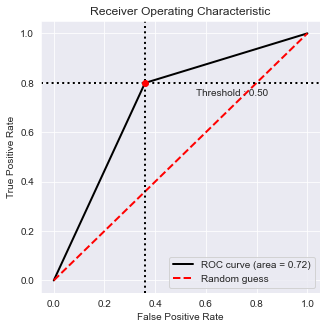

In [8]:
# Build the ANN model with the best parameters 
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(2,11,8,), random_state=43, max_iter=10000,activation='relu')

# fit the ANN model and show the results
clf.fit(X_res,y_res)
confusion_AUC(x_test,y_test,clf,2)

## 2-SVM

### Using Grid Search to find the best parameters

In [9]:

# Parameters for the grid search
param_grid = [{'C': [1300, 1400, 1500], 'gamma': [0.00001], 'kernel': ['rbf']},]

print( "balanced classes  with pre-processing - SVC")
# build the grid search, passing svc model and paramters to that 
grid = GridSearchCV(SVC(), param_grid,n_jobs=-1, refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(X_res, y_res) 

balanced classes  with pre-processing - SVC
Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  15 | elapsed:  1.9min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  3.4min remaining:   51.4s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.5min finished


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1300, 1400, 1500], 'gamma': [1e-05],
                          'kernel': ['rbf']}],
             verbose=3)

In [10]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 1400, 'gamma': 1e-05, 'kernel': 'rbf'}
SVC(C=1400, gamma=1e-05)


Confusion Matrix : 
 [[1595  679]
 [  77  207]]
Test accuracy =  0.7044566067240031
              precision    recall  f1-score   support

           0       0.95      0.70      0.81      2274
           1       0.23      0.73      0.35       284

    accuracy                           0.70      2558
   macro avg       0.59      0.72      0.58      2558
weighted avg       0.87      0.70      0.76      2558

F1 Score: 0.35384615384615387
AUC: 0.72%


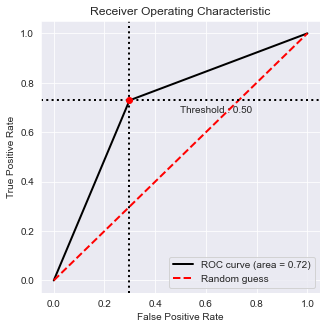

In [11]:
# build the svm model with the best paramters 
svm=SVC(C=1500, gamma=0.00001, kernel= 'rbf')
# fit the model 
svm.fit(X_res, y_res, )

# show the results
confusion_AUC(x_test,y_test,svm,2)


## 3- Random Forest 
### using grid search to find the best parameters 

In [12]:

# build the model 
rfc=RandomForestClassifier(random_state=42)
# parameters 
param_grid = { 'n_estimators': [2000,2500,3000],'max_features': ['auto'],'max_depth' : [10,15,20],'criterion' :['gini', 'entropy']}
# Grid search 
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, refit = True, verbose = 3)
# fit the grid
CV_rfc.fit(X_res, y_res)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] criterion=gini, max_depth=10, max_features=auto, n_estimators=2000 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=gini, max_depth=10, max_features=auto, n_estimators=2000, score=0.783, total=  22.7s
[CV] criterion=gini, max_depth=10, max_features=auto, n_estimators=2000 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.7s remaining:    0.0s


[CV]  criterion=gini, max_depth=10, max_features=auto, n_estimators=2000, score=0.760, total=  22.8s
[CV] criterion=gini, max_depth=10, max_features=auto, n_estimators=2000 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   45.5s remaining:    0.0s


[CV]  criterion=gini, max_depth=10, max_features=auto, n_estimators=2000, score=0.775, total=  22.7s
[CV] criterion=gini, max_depth=10, max_features=auto, n_estimators=2000 
[CV] C=1300, gamma=1e-05, kernel=rbf .................................
[CV] ..... C=1300, gamma=1e-05, kernel=rbf, score=0.716, total= 1.9min
[CV]  criterion=gini, max_depth=10, max_features=auto, n_estimators=2000, score=0.777, total=  22.6s
[CV] criterion=gini, max_depth=10, max_features=auto, n_estimators=2000 
[CV]  criterion=gini, max_depth=10, max_features=auto, n_estimators=2000, score=0.774, total=  23.5s
[CV] criterion=gini, max_depth=10, max_features=auto, n_estimators=2500 
[CV]  criterion=gini, max_depth=10, max_features=auto, n_estimators=2500, score=0.782, total=  27.8s
[CV] criterion=gini, max_depth=10, max_features=auto, n_estimators=2500 
[CV] C=1300, gamma=1e-05, kernel=rbf .................................
[CV] ..... C=1300, gamma=1e-05, kernel=rbf, score=0.723, total= 1.7min
[CV] C=1400, gamma=1

[CV]  criterion=gini, max_depth=20, max_features=auto, n_estimators=2500, score=0.943, total=  45.1s
[CV] criterion=gini, max_depth=20, max_features=auto, n_estimators=2500 
[CV]  criterion=gini, max_depth=20, max_features=auto, n_estimators=2500, score=0.937, total=  45.4s
[CV] criterion=gini, max_depth=20, max_features=auto, n_estimators=2500 
[CV]  criterion=gini, max_depth=20, max_features=auto, n_estimators=2500, score=0.940, total=  45.2s
[CV] criterion=gini, max_depth=20, max_features=auto, n_estimators=3000 
[CV]  criterion=gini, max_depth=20, max_features=auto, n_estimators=3000, score=0.940, total=  53.8s
[CV] criterion=gini, max_depth=20, max_features=auto, n_estimators=3000 
[CV]  criterion=gini, max_depth=20, max_features=auto, n_estimators=3000, score=0.936, total=  55.0s
[CV] criterion=gini, max_depth=20, max_features=auto, n_estimators=3000 
[CV]  criterion=gini, max_depth=20, max_features=auto, n_estimators=3000, score=0.943, total=  54.5s
[CV] criterion=gini, max_dept

[CV]  criterion=entropy, max_depth=20, max_features=auto, n_estimators=2500, score=0.932, total=  48.8s
[CV] criterion=entropy, max_depth=20, max_features=auto, n_estimators=2500 
[CV]  criterion=entropy, max_depth=20, max_features=auto, n_estimators=2500, score=0.935, total=  49.1s
[CV] criterion=entropy, max_depth=20, max_features=auto, n_estimators=3000 
[CV]  criterion=entropy, max_depth=20, max_features=auto, n_estimators=3000, score=0.934, total=  58.1s
[CV] criterion=entropy, max_depth=20, max_features=auto, n_estimators=3000 
[CV]  criterion=entropy, max_depth=20, max_features=auto, n_estimators=3000, score=0.930, total= 1.1min
[CV] criterion=entropy, max_depth=20, max_features=auto, n_estimators=3000 
[CV]  criterion=entropy, max_depth=20, max_features=auto, n_estimators=3000, score=0.936, total=  59.9s
[CV] criterion=entropy, max_depth=20, max_features=auto, n_estimators=3000 
[CV]  criterion=entropy, max_depth=20, max_features=auto, n_estimators=3000, score=0.932, total=  57

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 57.2min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20], 'max_features': ['auto'],
                         'n_estimators': [2000, 2500, 3000]},
             verbose=3)

In [13]:
# print the best the parmeters
print(CV_rfc.best_params_)

{'criterion': 'gini', 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 3000}


Confusion Matrix : 
 [[1650  624]
 [  92  192]]
Test accuracy =  0.7200938232994527
              precision    recall  f1-score   support

           0       0.95      0.73      0.82      2274
           1       0.24      0.68      0.35       284

    accuracy                           0.72      2558
   macro avg       0.59      0.70      0.59      2558
weighted avg       0.87      0.72      0.77      2558

F1 Score: 0.34909090909090906
AUC: 0.70%


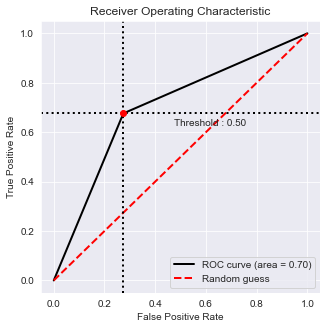

In [14]:
# Build the random forest with the best parametes

rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 3000, max_depth=7, criterion='entropy')
# fit the model 
rfc1.fit(X_res, y_res)

# show the results 
confusion_AUC(x_test,y_test,rfc1,2)